# Behavior analysis
This analysis covers the foraging task in the physical setup. More information about that task can be found in the `TreadmillTracker` [repository](https://github.com/ckemere/TreadmillTracker).

Planned outline: develop each analysis for single session, then add batch feature
- Basic analysis: run as single session or batch mode
    - Harvest rate
    - Residence and travel time
    - Lick stats
- Patch dynamics: run as single session or batch mode
    - Reward rate vs. time in patch
    - Lick rate vs. time in patch
- Other analysis...

## Initial setup

### Imports

In [1]:
# Numerical tools
import numpy as np
import math
import scipy.stats as stats

# Plotting tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# OS tools
from tempfile import TemporaryFile
import time
import os
import getpass

# Custom modules
import sys
sys.path.insert(0, '../python/')
import util
import session
import plot
import analysis
import ephys

mountainlab_pytools module not installed. Some functions from the ephys package may not be available.


### Helper classes

In [2]:
# Create Plotter object
plotter = plot.Plotter()

# Create Google Drive interface
service = util.GoogleDriveService()

### Helper functions

In [3]:
def upload_figure(name, folder_id, fmt='pdf'):
    with TemporaryFile(suffix='.{}'.format(fmt)) as f:
        plt.savefig(f, format=fmt)
        service.upload(file_stream=f,
                       filename=name,
                       folder_ids=folder_id,
                       mime_type='application/octet-stream',
                       chunk_size=1024*256*4,
                       verbose=True)

def get_permission(d):
    # Allow read/write permissions from/to directory
    password = getpass.getpass()
    command = 'sudo -S chmod 777 {}'.format(media_dir) # -S enables input from stdin
    os.system('echo {} | {}'.format(password, command))
    
def get_filepath(mouse_dir, day, overwrite=False):
    filepath = '/'.join([mouse_dir , 'sess_{:02d}.p'.format(day)])
    if overwrite:
        return filepath
    else:
        i = 0
        while os.path.isfile(filepath):
            i += 1
            filepath = '/'.join([mouse_dir, 'sess_{:02d}-{}.p'.format(day, i)])
        return filepath

def save_sessions(mouse_id, results_dir, overwrite=False, verbose=True):
    mouse_dir = '/'.join([results_dir, mouse_id])
    if not os.path.isdir(mouse_dir):
        try:
            os.mkdir(mouse_dir)
        except PermissionError:
            print('Need password for permission to write to {}'.format(mouse_dir))
            get_permission(mouse_dir)
    
    if verbose:
        print('Saving sessions for mouse {} to {}...'.format(mouse_id, mouse_dir), end=' ')
    for sess in sessions[mouse_id]:
        filepath = get_filepath(mouse_dir, sess.day, overwrite=overwrite)
        sess.save(filepath)
    if verbose:
        print('done.')
    
def load_sessions(mouse_id, results_dir, verbose=True):
    mouse_dir = '/'.join([results_dir, mouse_id])
    if verbose:
        print('Loading sessions for mouse {} from {}...'.format(mouse_id, mouse_dir), end=' ')
        
    sessions = []
    for filename in os.listdir(mouse_dir):
        try:
            filepath = '/'.join([mouse_dir, filename])
            sess = session.TTSession()
            sess.load(filepath)
            sessions.append(sess)
        except PermissionError:
            print('Need password for permission to read from {}'.format(mouse_dir))
            get_permission(mouse_dir)
    if verbose:
        print('done.')
    
    return sessions

## Single session analysis

### Load session

In [270]:
# Create results directory
folder_id = service.get_folder_ids(foldername='R001', 
                                   exact_match=True, 
                                   parent='track_task_analysis')

# Load data file
data_filename = 'R001_d34_2019-09-11-1435_log.txt'
load_fn = lambda x: np.loadtxt(x, delimiter=',')
data = util.bytes_to_object(service.download(filename=data_filename),
                            ob_type='numpy',
                            load_fn=load_fn)

# Load params file
params_filename = 'R001_d34_2019-09-11-1435_params.json'
params = util.bytes_to_object(service.download(filename=params_filename),
                              ob_type='json')

# Create Session objects
sess = session.TTSession(data, params)

Exception ignored in: <ssl.SSLSocket fd=59, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.85.51.25', 36562), raddr=('172.217.12.74', 443)>
Exception ignored in: <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.85.51.25', 48492), raddr=('172.217.9.10', 443)>


### Session summary

In [271]:
T = sess.analyzed_time
t_patch = sess.get_patch_times()
#t_lick = analysis.get_lick_decisions(sess)
t_lick = sess.get_lick_times()
t_motor = sess.get_motor_times()

100% complete...
File sucessfully uploaded.


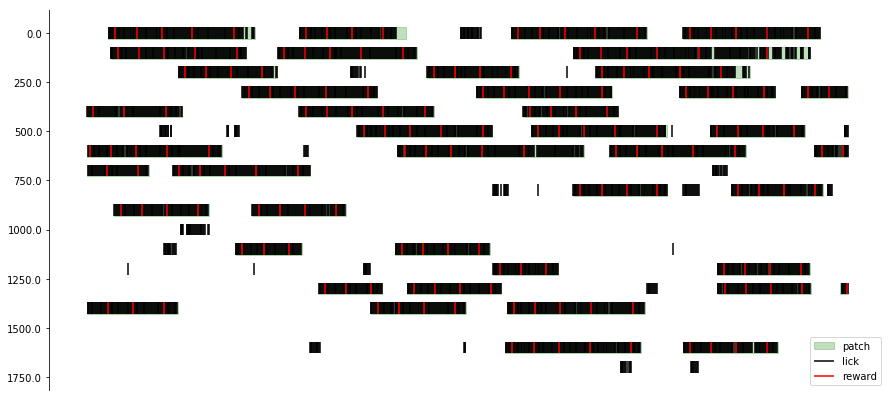

In [272]:
plotter.plot_session_summary(T=T,
                             t_patch=t_patch,
                             t_lick=t_lick,
                             t_motor=t_motor,
                             dt_chunk=100,
                             figsize=(15, 7))
save_figure('{:02d}_summary.png'.format(sess.day), fmt='png')

### Harvest rate

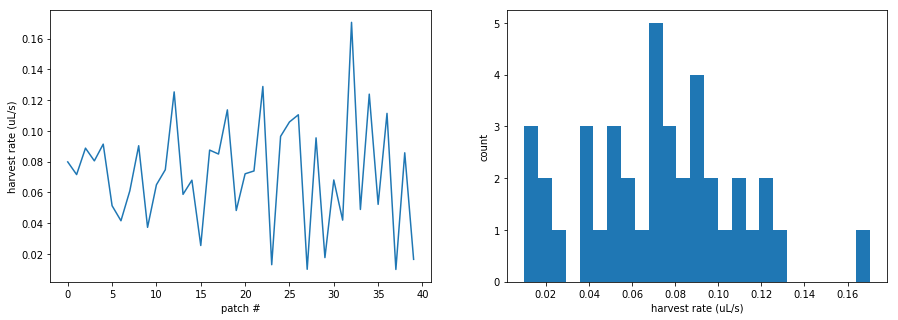

In [273]:
# Grab harvest rate over sessions
hr_obs = sess.get_harvest_rate(metric='observed', per_patch=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot harvest rate over patches
ax[0].plot(hr_obs)
ax[0].set_xlabel('patch #')
ax[0].set_ylabel('harvest rate (uL/s)')

# Plot distribution of harvest rates
ax[1].hist(hr_obs, bins=25)
ax[1].set_xlabel('harvest rate (uL/s)')
ax[1].set_ylabel('count');

### Residence and travel times

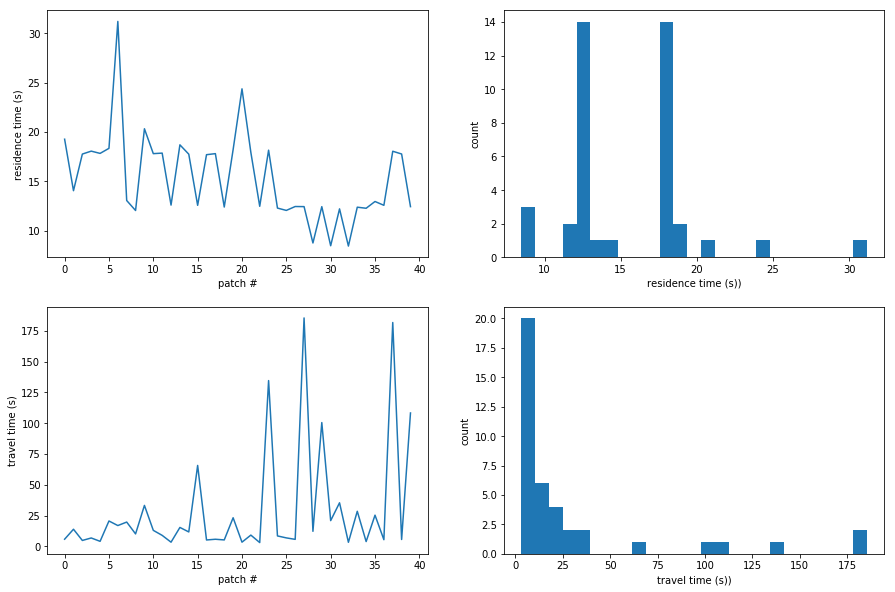

In [274]:
# Get residence and travel times
t_p_obs = sess.get_patch_durations()
t_t_obs = sess.get_interpatch_durations()

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot residence time over patches
ax[0, 0].plot(t_p_obs)
ax[0, 0].set_xlabel('patch #')
ax[0, 0].set_ylabel('residence time (s)')

# Plot distribution of residence times
ax[0, 1].hist(t_p_obs, bins=25)
ax[0, 1].set_xlabel('residence time (s))')
ax[0, 1].set_ylabel('count')

# Plot travel time over patches
ax[1, 0].plot(t_t_obs)
ax[1, 0].set_xlabel('patch #')
ax[1, 0].set_ylabel('travel time (s)')

# Plot distribution of travel times
ax[1, 1].hist(t_t_obs, bins=25)
ax[1, 1].set_xlabel('travel time (s))')
ax[1, 1].set_ylabel('count');

### Combined data

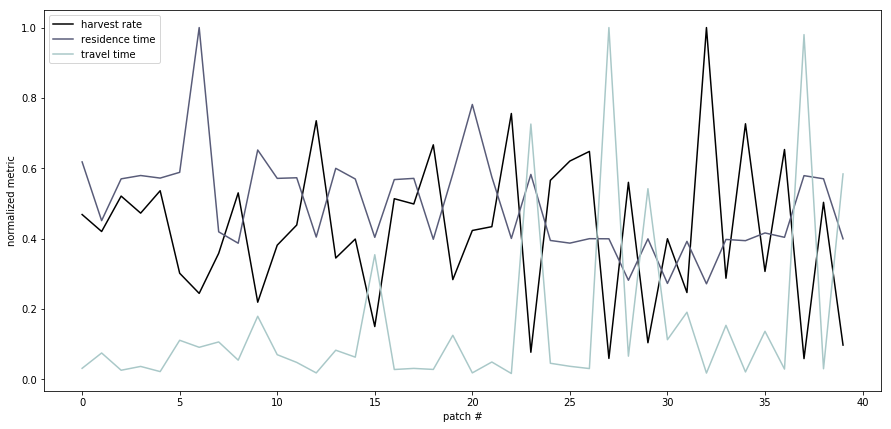

In [275]:
# Plot normalized harvest rate, residence time, and travel time per patch
fig, ax = plt.subplots(figsize=(15, 7))
cmap = plt.get_cmap('bone')

ax.plot(hr_obs/np.max(hr_obs), color=cmap(0.0), label='harvest rate')
ax.plot(t_p_obs/np.max(t_p_obs), color=cmap(0.4), label='residence time')
ax.plot(t_t_obs/np.max(t_t_obs), color=cmap(0.75), label='travel time')
ax.set_xlabel('patch #')
ax.set_ylabel('normalized metric')
ax.legend();

### Task engagement

#### By travel time

In [ ]:
# Generate models
linear_normal = Gaussian()
linear_normal.fit(t_t_obs)
log_normal = LogGaussian()
log_normal.fit(t_t_obs)
poisson = Poisson(0)
poisson.fit(t_t_obs, interevent=True)

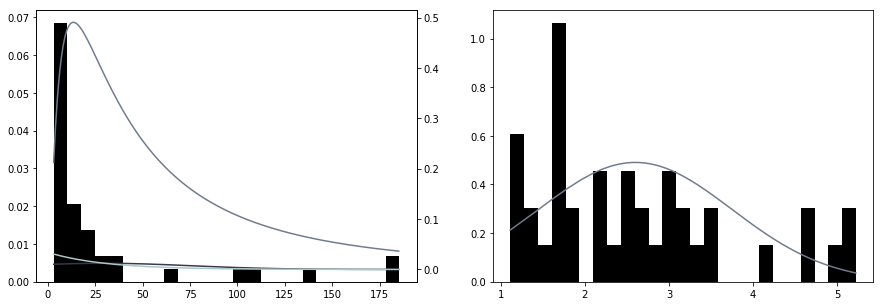

In [451]:
# Plot distribution of travel time
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
t = np.arange(np.min(t_t_obs), np.max(t_t_obs))

# Linear space
ax[0].hist(t_t_obs, bins=25, density=True, color=cmap(0.0))
ax2 = ax[0].twinx()
ax2.plot(t, linear_normal._pdf(t), color=cmap(0.25))
ax2.plot(t, log_normal._pdf(t), color=cmap(0.50))
ax2.plot(t, poisson._pdf(t), color=cmap(0.75))

# Log space
ax[1].hist(np.log(t_t_obs), bins=25, density=True, color=cmap(0.0))
ax[1].plot(np.log(t), log_normal._pdf(t), color=cmap(0.50))

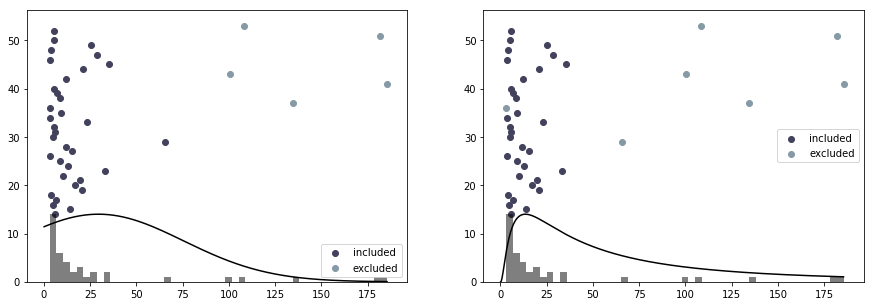

In [454]:
# Choose cutoffs
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
cmap = plt.get_cmap('bone')
tt = np.linspace(0.1, t_t_obs.max(), num=1000) # for pdf
thresh = 0.80 # percentile

# Iterate over models
for i, model in enumerate([linear_normal, log_normal]):
    # Get indices of included times
    idx = model.test_statistic(t_t_obs, 
                               distribution='f', 
                               test='<=', 
                               q=thresh)
    
    # Calculate distribution of times within model
    counts, bins, _ = ax[i].hist(t_t_obs, bins=50, 
                                 color=cmap(0.0), alpha=0.5)
    pdf = model.pdf(tt)
    
    # Plot distributions and results
    ax[i].plot(tt, pdf/pdf.max()*counts.max(), color=cmap(0.0))
    ax[i].scatter(t_t_obs[idx], np.arange(len(t_t_obs))[idx] + np.max(counts), 
                color=cmap(0.3), label='included')
    ax[i].scatter(t_t_obs[~idx], np.arange(len(t_t_obs))[~idx] + np.max(counts), 
                color=cmap(0.6), label='excluded')

    ax[i].legend()

### Lick analysis

(0.0, 1.070870185987362)

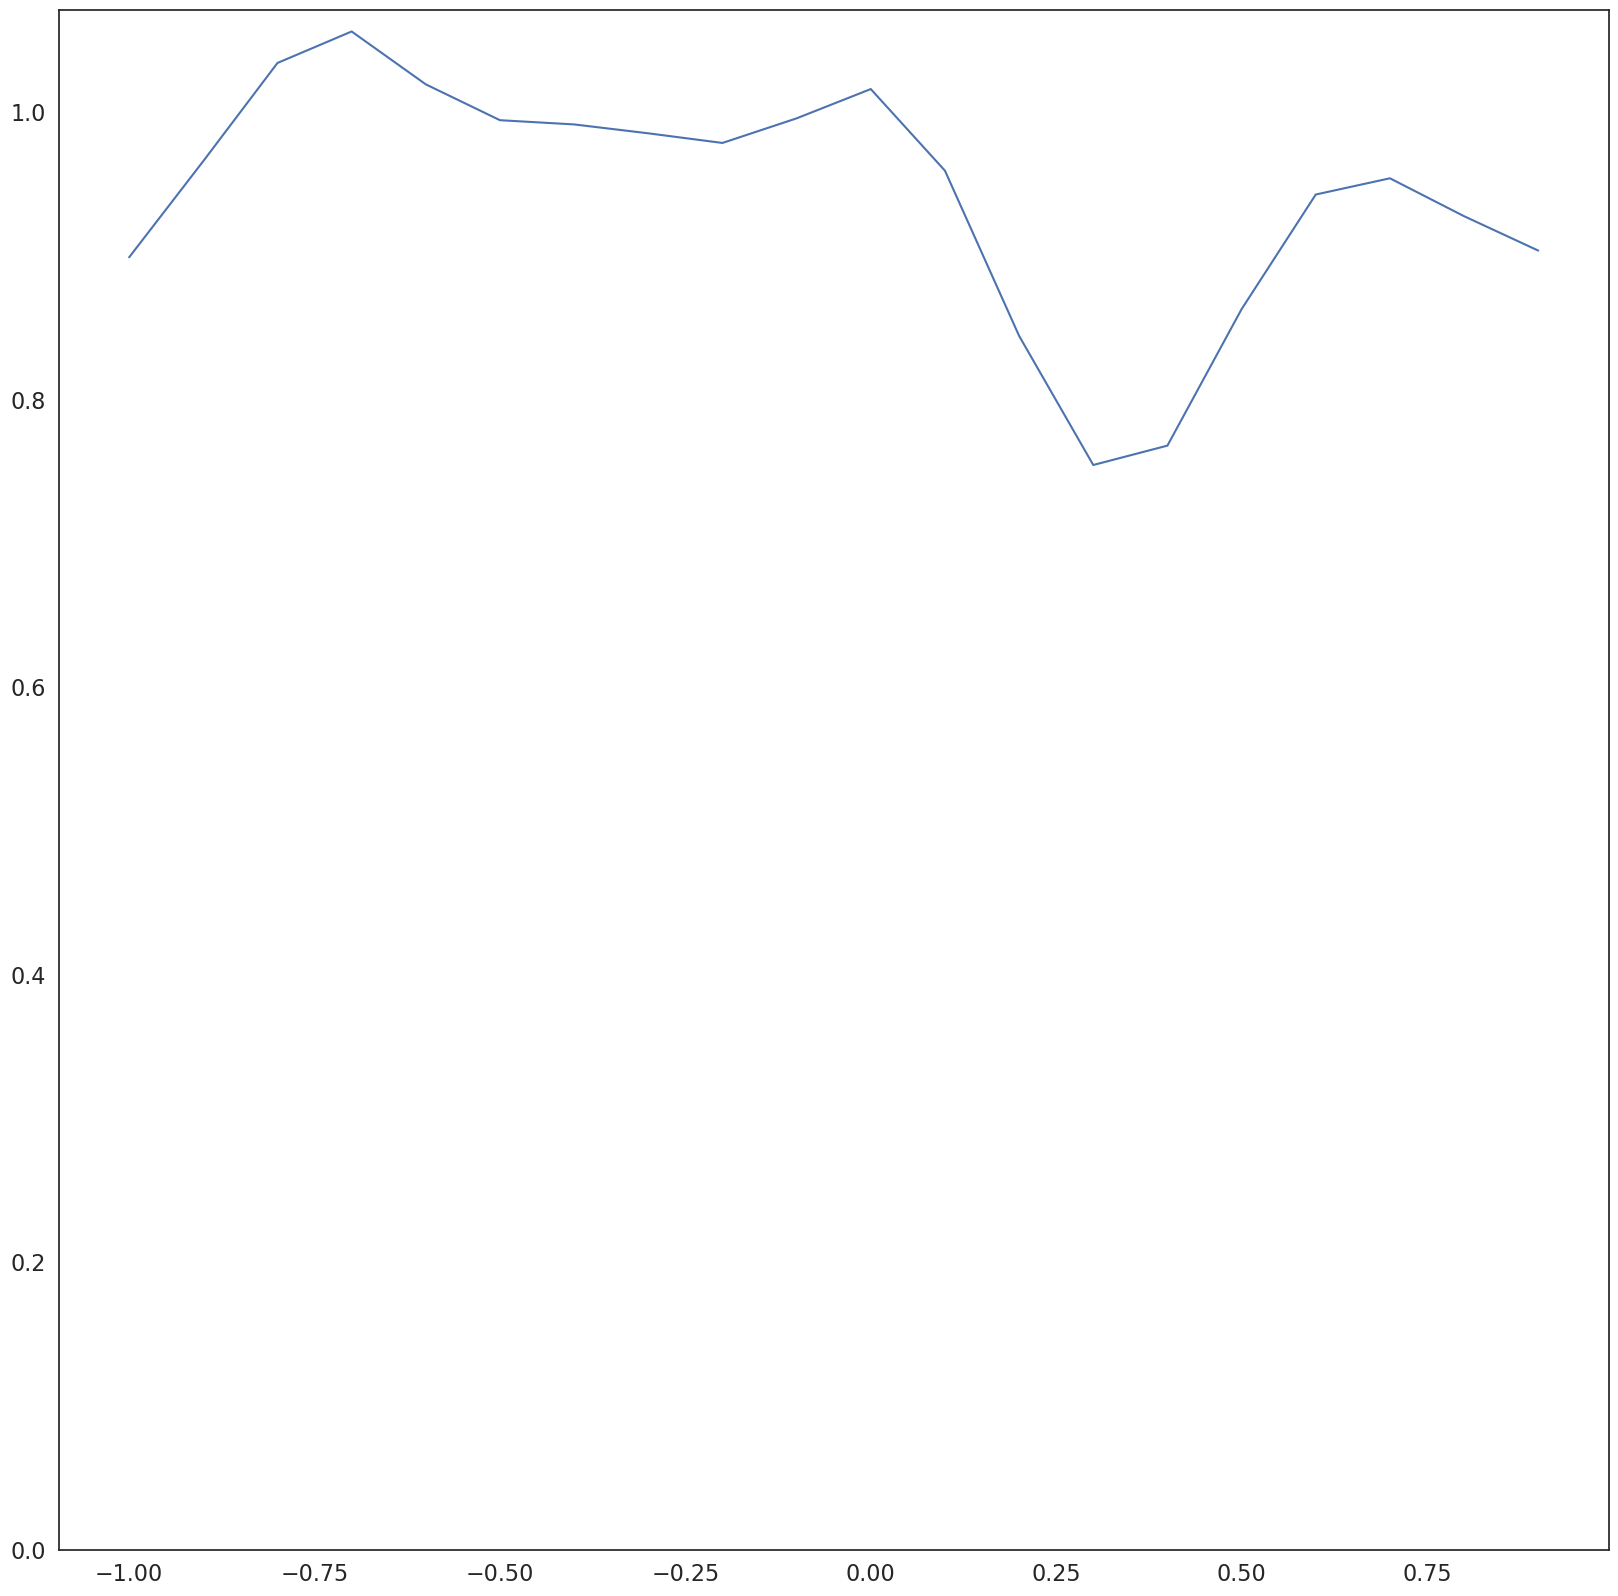

In [246]:
# Create bins
dt_bin = 0.1
num_bins = int(sess.analyzed_time / dt_bin)
t_bins = np.linspace(0.0, int(sess.analyzed_time), num=num_bins)

# Get lick counts
t_lick = sess.get_lick_times()
n_lick = util.in_interval(t_lick, 
                          t_bins[:-1], 
                          t_bins[1:], 
                          query='interval')

# Smooth lick rate
f_lick = ephys.smooth_spike_counts(counts=n_lick,
                                   dt_bin=dt_bin,
                                   method='kernel',
                                   kernel_type='Gaussian',
                                   sigma=dt_bin)

# Evaluate lick rate around reward times
t_motor = sess.get_motor_times()
t_window, f_window = util.get_peristimulus_data(f_lick,
                                                t_bins[:-1],
                                                t_motor,
                                                window=[-1.0, 1.0],
                                                fs=1.0/dt_bin)

# Plot results
fig, ax = plt.subplots()
ax.plot(t_window, np.mean(f_window, axis=0))
ax.set_ylim([0.0, ax.get_ylim()[1]])

## Batch analysis

### Load sessions

In [230]:
# Settings
mouse_ids = ['R001', 'R002', 'R003', 'R004']
session_range = [1, 61]
media_dir = '/media/james/data/foraging/linear_track'
check_updates = False
upload_folder_id = service.get_folder_ids(foldername='R001-R004', 
                                          exact_match=True, 
                                          parent='track_task_analysis')

In [231]:
# Load sessions
sessions = {}
load_fn = lambda x: np.loadtxt(x, delimiter=',')
for mouse_id in mouse_ids:
    # Load all local sessions
    print('Loading local sessions for mouse {}...'.format(mouse_id), end=' ')
    sessions[mouse_id] = load_sessions(mouse_id, media_dir, verbose=False)
    print('done.')
    
    if check_updates:
        # Get all session IDs for comparison later
        session_ids = [sess.params['Info']['Session'] for sess in sessions[mouse_id]]

        # Get parent folder ID
        parent_id = service.get_folder_ids(foldername=mouse_id,
                                           unique=True,
                                           exact_match=True,
                                           parent='track_data')[0]

        # Get param file IDs and filenames
        param_fids = service.get_file_ids(filename='.json',
                                          exact_match=False,
                                          parent=parent_id)
        param_filenames = service.get_file_metadata(file_ids=param_fids, fields='name')
        param_filenames = [f['name'] for f in param_filenames]

        # Find corresponding log file IDs
        suffix = '_params.json'
        log_filenames = [f[:-len(suffix)] + '_log.txt' for f in param_filenames]
        log_fids = []
        for log_filename in log_filenames:
            log_fids.append(service.get_file_ids(filename=log_filename,
                                                 exact_match=True,
                                                 parent=parent_id)[0])

        # Load param and data files in session range that are not already loaded
        print('Downloading sessions for mouse %s:' % mouse_id)
        for param_fid, log_fid in zip(param_fids, log_fids):
            params = util.bytes_to_object(service.download(file_id=param_fid), ob_type='json')
            session_id = params['Info'].get('Session', 0)
            if ((session_id >= session_range[0]) 
                and (session_id <= session_range[1])
                and (session_id not in session_ids)):
                print('Downloading session %d...' % session_id, end=' ')
                log = util.bytes_to_object(service.download(file_id=log_fid),
                                           ob_type='numpy', 
                                           load_fn=load_fn)
                sessions[mouse_id].append(session.TTSession(log, params))
                print('done.')

        print()

Loading local sessions for mouse R001... done.
Loading local sessions for mouse R002... done.
Loading local sessions for mouse R003... done.
Loading local sessions for mouse R004... done.


In [320]:
# CLear old vars if needed
for mouse_id in mouse_ids:
    for sess in sessions[mouse_id]:
        sess.clear_vars()

In [232]:
# Save downloaded sessions
for mouse_id in mouse_ids:
    save_sessions(mouse_id, media_dir, overwrite=True)

Saving sessions for mouse R001 to /media/james/data/foraging/linear_track/R001... done.
Saving sessions for mouse R002 to /media/james/data/foraging/linear_track/R002... done.
Saving sessions for mouse R003 to /media/james/data/foraging/linear_track/R003... done.
Saving sessions for mouse R004 to /media/james/data/foraging/linear_track/R004... done.


In [233]:
# Get days for faster downstream processing
days = {}
for mouse_id in mouse_ids:
    days[mouse_id] = np.array([sess.day for sess in sessions[mouse_id]])

In [234]:
# Criterion 1: poor water-deprivation (e.g. first days of week)
exclude_days = np.array([])

In [235]:
# Criterion 2: minimum number of patches
days_ = np.arange(session_range[0], session_range[1])
include_days = {}
for mouse_id in mouse_ids:
    include_days[mouse_id] = []
    for sess in sessions[mouse_id]:
        try:
            if sess.n_patches >= 20:
                include_days[mouse_id].append(sess.day)
        except (UserWarning, IndexError) as w:
            pass
print(include_days)

{'R001': [32, 27, 35, 36, 60, 44, 45, 21, 28, 47, 31, 18, 48, 39, 38, 58, 55, 16, 33, 26, 17, 22, 40, 46, 42, 11, 34, 37, 50, 41, 20, 30, 59, 29, 14, 49, 51, 23, 43, 56, 25], 'R002': [32, 27, 35, 36, 60, 44, 45, 21, 28, 13, 5, 47, 31, 18, 48, 39, 38, 58, 16, 33, 17, 22, 40, 46, 34, 37, 50, 41, 30, 59, 29, 14, 49, 51, 23, 43, 56, 25], 'R003': [32, 27, 35, 36, 60, 44, 45, 21, 28, 13, 5, 47, 54, 18, 48, 39, 38, 55, 33, 26, 17, 22, 40, 53, 46, 42, 34, 37, 50, 41, 30, 59, 29, 14, 49, 51, 23, 43, 56, 25], 'R004': [32, 27, 36, 15, 60, 44, 45, 21, 28, 10, 13, 5, 47, 54, 31, 18, 48, 39, 30, 38, 58, 55, 33, 26, 17, 22, 40, 53, 46, 34, 37, 50, 41, 20, 30, 59, 14, 4, 49, 51, 23, 43, 1, 6, 56, 25]}


### Experimental conditions

In [236]:
# Get unique experimental conditions
cond = {} # conditions of each session
vals = [] # hash values of condition
vals_cond = {} # hash value --> condition
cond_params = {} # condition --> parameters
i = 0
for mouse_id in mouse_ids:
    cond[mouse_id] = []
    for sess in sessions[mouse_id]:
        # Get tau if available
        try:
            tau = sess.params['Reward']['tau']
        except KeyError:
            tau = -1
        
        # Get task type
        task = sess.params['Info']['Task']
        
        # Get unique value
        val = hash(str(tau) + task)
        if val in vals:
            # Condition already found. Find appropriate ID.
            cond[mouse_id].append(vals_cond[val])
        else:
            # Condition is new. Add to dict.
            vals.append(val)
            vals_cond[val] = i
            cond_params[i] = [tau, task]
            cond[mouse_id].append(vals_cond[val])
            i += 1
            
    cond[mouse_id] = np.array(cond[mouse_id])
            
print(cond_params)

{0: [12.0, 'LinearTrack'], 1: [-1, 'LinearTrack'], 2: [24.0, 'LinearTrack'], 3: [12.0, 'STrack'], 4: [24.0, 'LinearTrackBarriers'], 5: [24.0, 'STrack'], 6: [12.0, 'LinearTrackBarriers']}


In [255]:
# Order for plotting later on
exclude_cond = [1]
cond_order = [0, 2, 6, 4, 3, 5]

### Raw data
These plots will show all data without applying inclusion criteria.

#### Harvest rate

In [238]:
# Grab harvest rate over sessions
r_obs = {} # total reward per patch
hr_obs = {} # observed rate
hr_max = {} # maximum rate given leaving decisions
hr_opt = {} # optimal rate (MVT) given environment
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)

    # Placeholders
    r_obs[mouse_id] = []
    hr_obs[mouse_id] = []
    hr_max[mouse_id] = []
    hr_opt[mouse_id] = []

    for sess in sessions[mouse_id]:
        print('Processing session %d...' % sess.day, end=' ')
        try:
            hr_obs_, r_obs_, t_seg_ = sess.get_harvest_rate(metric='observed', 
                                                            per_patch=True,
                                                            return_all=True)
            r_obs[mouse_id].append(r_obs_)
            hr_obs[mouse_id].append(hr_obs_)
            #hr_max[mouse_id].append(sess.get_harvest_rate(metric='max', per_patch=True))
            #hr_opt[mouse_id].append(sess.get_harvest_rate(metric='optimal', per_patch=True))
            print('done.')
        except IndexError as w: # unanalyzable session
            print(w)
            r_obs[mouse_id].append(np.array([np.nan]))
            hr_obs[mouse_id].append(np.array([np.nan]))
            #hr_max[mouse_id].append(np.array([np.nan]))
            #hr_opt[mouse_id].append(np.array([np.nan]))

    print()    

Analyzing mouse R001:
Processing session 32... done.
Processing session 12... done.
Processing session 27... done.
Processing session 35... done.
Processing session 8... done.
Processing session 9... done.
Processing session 36... done.
Processing session 15... done.
Processing session 60... done.
Processing session 44... done.
Processing session 45... done.
Processing session 21... done.
Processing session 28... done.
Processing session 10... done.
Processing session 13... done.
Processing session 5... done.
Processing session 52... done.
Processing session 47... done.
Processing session 54... done.
Processing session 31... done.
Processing session 3... done.
Processing session 18... done.
Processing session 48... done.
Processing session 39... done.
Processing session 38... done.
Processing session 58... done.
Processing session 55... done.
Processing session 16... done.
Processing session 2... index 0 is out of bounds for axis 0 with size 0
Processing session 33... done.
Processing 

100% complete...
File sucessfully uploaded.


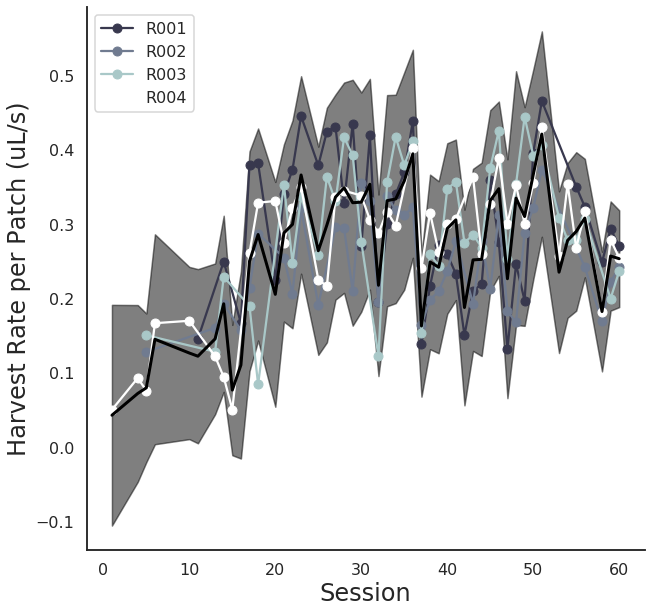

In [333]:
# Plot results
rc_params = {'axes.titlesize': 24,
             'axes.labelsize': 24,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'legend.fontsize': 16,
             'legend.facecolor': 'inherit'}
plotter = plot.Plotter(rcParams=rc_params)
plotter.set_cmap('bone')
#day_range = np.arange(1, 65)[~np.isin(np.arange(1, 65), exclude_days)]
plotter.plot_harvest_rates(days, 
                           hr_obs, 
                           day_range=include_days,
                           plot_traces=True, 
                           err='std',
                           err_plot='fill', 
                           c=0.0)
plotter.ax.legend(loc='upper left')

upload_figure('harvest_rate_naive.pdf', upload_folder_id, fmt='pdf')

#### Residence and travel time

In [240]:
# Grab patch residence and travel times
t_p_obs = {}
t_p_opt = {}
t_t_obs = {}
t_t_opt = {}
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)

    # Placeholders
    t_p_obs[mouse_id] = []
    t_p_opt[mouse_id] = []
    t_t_obs[mouse_id] = []
    t_t_opt[mouse_id] = []

    for sess, day in zip(sessions[mouse_id], days[mouse_id]):
        print('Processing session %d... ' % day, end=' ')

        try:
            t_p_obs[mouse_id].append(sess.get_patch_durations())
            t_t_obs[mouse_id].append(sess.get_interpatch_durations())   
        except (UserWarning, IndexError) as w: # unanalyzable session
            print(w)
            t_p_obs[mouse_id].append(np.asarray([np.nan]))
            t_t_obs[mouse_id].append(np.asarray([np.nan]))
            
        try:
            _, _, t_p_opt_, t_t_opt_ = sess.get_harvest_rate(metric='optimal', return_all=True)
            t_p_opt[mouse_id].append(np.asarray([t_p_opt_]))
            t_t_opt[mouse_id].append(np.asarray([t_t_opt_]))
            print('done.')
        except (UserWarning, IndexError) as w: # no reward decay params or unanalyzable session
            print(w)
            t_p_opt[mouse_id].append(np.asarray([np.nan]))
            t_t_opt[mouse_id].append(np.asarray([np.nan]))

    print()

Analyzing mouse R001:
Processing session 32...  done.
Processing session 12...  Reward depletion parameters not specified.
Processing session 27...  done.
Processing session 35...  done.
Processing session 8...  Reward depletion parameters not specified.
Processing session 9...  Reward depletion parameters not specified.
Processing session 36...  done.
Processing session 15...  Reward depletion parameters not specified.
Processing session 60...  done.
Processing session 44...  done.
Processing session 45...  done.
Processing session 21...  done.
Processing session 28...  done.
Processing session 10...  Reward depletion parameters not specified.
Processing session 13...  Reward depletion parameters not specified.
Processing session 5...  Reward depletion parameters not specified.
Processing session 52...  done.
Processing session 47...  done.
Processing session 54...  done.
Processing session 31...  done.
Processing session 3...  Reward depletion parameters not specified.
Processing ses

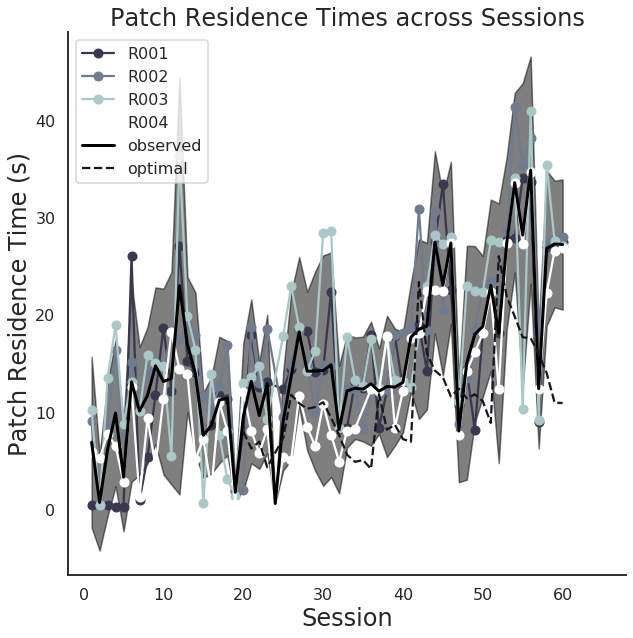

In [241]:
# Plot results
rc_params = {'axes.titlesize': 24,
             'axes.labelsize': 24,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'legend.fontsize': 16,
             'legend.facecolor': 'inherit'}
plotter = plot.Plotter(rcParams=rc_params)
plotter.set_cmap('bone')
#day_range = np.arange(50)[~np.isin(np.arange(50), exclude_days)]
plotter.plot_residence_times(days, 
                             t_p_obs, 
                             t_p_opt,
                             day_range=None,
                             plot_traces=True, 
                             err='std', 
                             err_plot='fill', 
                             c=0.0)
plt.legend(loc='upper left');

#### Decay rate variability

In [175]:
# Get decay rate of each session
tau = {}
for mouse_id in mouse_ids:
    tau[mouse_id] = []
    for sess in sessions[mouse_id]:
         # Get tau if available
        try:
            tau[mouse_id].append(sess.params['Reward']['tau'])
        except KeyError:
            tau[mouse_id].append(-1)  

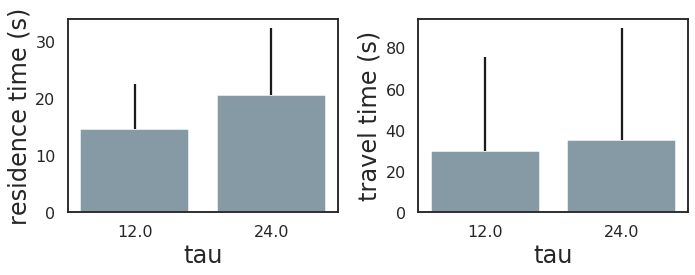

In [176]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cmap = plt.get_cmap('bone')

# Collect patch data by decay rate
t_p_plot, tau_plot = util.get_patch_statistics(t_p_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)
t_p_err, tau_plot = util.get_patch_statistics(t_p_obs, 
                                    ids=tau, 
                                    method='std', 
                                    return_all=False)

# Plot residence times
plot_idx = np.argwhere(tau_plot > 0.0).flatten()
yerr = np.vstack([np.zeros(len(plot_idx)), t_p_err[plot_idx]])
ax[0].bar(np.arange(len(plot_idx)), 
          t_p_plot[plot_idx], 
          yerr=yerr,
          color=cmap(0.60))
ax[0].set_xticks(np.arange(len(plot_idx)))
ax[0].set_xticklabels(tau_plot[plot_idx])
ax[0].set_xlabel('tau')
ax[0].set_ylabel('residence time (s)')

# Collect patch data by decay rate
t_t_plot, tau_plot = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)
t_t_err, tau_plot = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='std', 
                                    return_all=False)

# Plot travel times
plot_idx = np.argwhere(tau_plot > 0.0).flatten()
yerr = np.vstack([np.zeros(len(plot_idx)), t_t_err[plot_idx]])
ax[1].bar(np.arange(len(plot_idx)), 
          t_t_plot[plot_idx], 
          yerr=yerr,
          color=cmap(0.60))
ax[1].set_xticks(np.arange(len(plot_idx)))
ax[1].set_xticklabels(tau_plot[plot_idx])
ax[1].set_xlabel('tau')
ax[1].set_ylabel('travel time (s)')

plt.tight_layout();

In [177]:
t_p_plot, tau_plot = util.get_patch_statistics(t_p_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)

<BarContainer object of 2 artists>

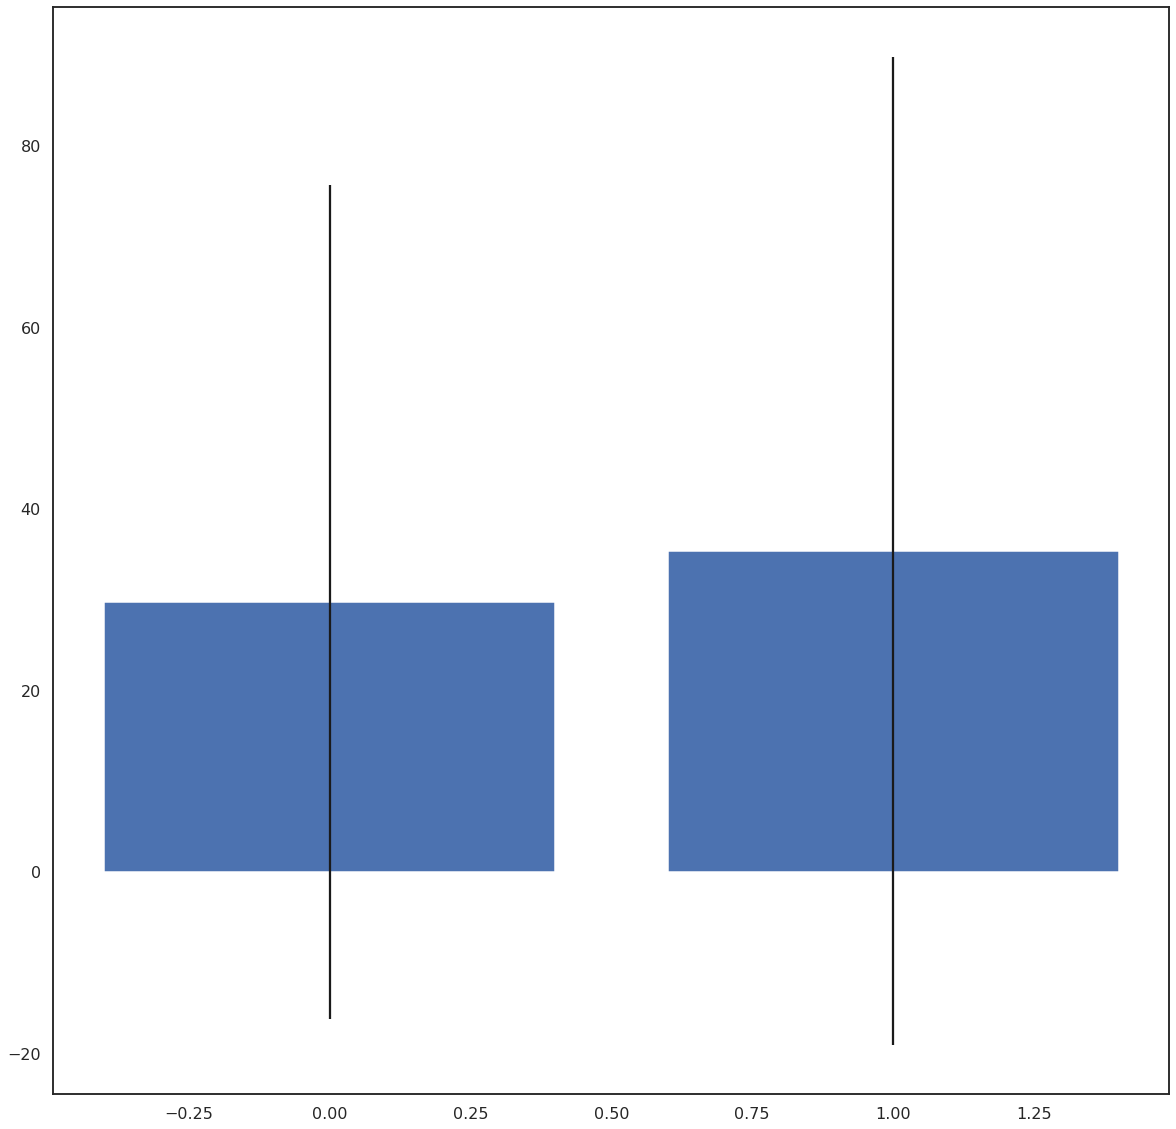

In [178]:
# Collect travel time data by decay rate
data, tau_ = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)
err, tau_ = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='std', 
                                    return_all=False)

# Plot results
plot_idx = np.argwhere(tau_ > 0.0).flatten()
plt.bar(np.arange(len(plot_idx)), data[plot_idx], yerr=err[plot_idx])

#### Lick and poke analysis
Answer two questions:
- How does lick rate vary across patch? around reward?
- How often do they poke in the wrong nose cone?

In [242]:
# Placeholders
lick_stats = {'n_total': {},
              'n_patch': {},
              'n_interpatch': {},
              'f_patch': {},
              'f_interpatch': {}}

# Get stats over sessions
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)

    # Placeholders
    for k in lick_stats.keys():
        lick_stats[k][mouse_id] = []

    for sess in sessions[mouse_id]:
        print('Processing session %d...' % sess.day, end=' ')

        # Add stats in format: lick_stats[key][mouse]
        try:
            lick_stats_ = analysis.get_lick_stats(sess, min_interval=0.0)
            for k in lick_stats.keys():
                lick_stats[k][mouse_id].append(lick_stats_[k])
            print('done.')
        except (UserWarning, IndexError) as w: # unanalyzable session
            print(w)
            for k in lick_stats.keys():
                lick_stats[k][mouse_id].append(np.asarray([np.nan]))

    print()

print('Done.')

Analyzing mouse R001:
Processing session 32... done.
Processing session 12... Pin labels not available for session.
Processing session 27... Licks detected simultaneously on multiple sensors.
Processing session 35... done.
Processing session 8... Pin labels not available for session.
Processing session 9... Pin labels not available for session.
Processing session 36... done.
Processing session 15... Licks detected simultaneously on multiple sensors.
Processing session 60... done.
Processing session 44... done.
Processing session 45... done.
Processing session 21... done.
Processing session 28... done.
Processing session 10... Pin labels not available for session.
Processing session 13... Pin labels not available for session.
Processing session 5... Pin labels not available for session.
Processing session 52... done.
Processing session 47... done.
Processing session 54... done.
Processing session 31... done.
Processing session 3... Pin labels not available for session.
Processing sessio

Processing session 39... done.
Processing session 30... done.
Processing session 38... done.
Processing session 58... done.
Processing session 55... done.
Processing session 16... Licks detected simultaneously on multiple sensors.
Processing session 2... Pin labels not available for session.
Processing session 33... done.
Processing session 26... Licks detected simultaneously on multiple sensors.
Processing session 17... done.
Processing session 22... Licks detected simultaneously on multiple sensors.
Processing session 19... done.
Processing session 40... done.
Processing session 53... done.
Processing session 46... done.
Processing session 42... done.
Processing session 11... Pin labels not available for session.
Processing session 34... done.
Processing session 37... done.
Processing session 50... done.
Processing session 41... done.
Processing session 20... done.
Processing session 30... done.
Processing session 59... done.
Processing session 29... done.
Processing session 24... do

100% complete...
File sucessfully uploaded.


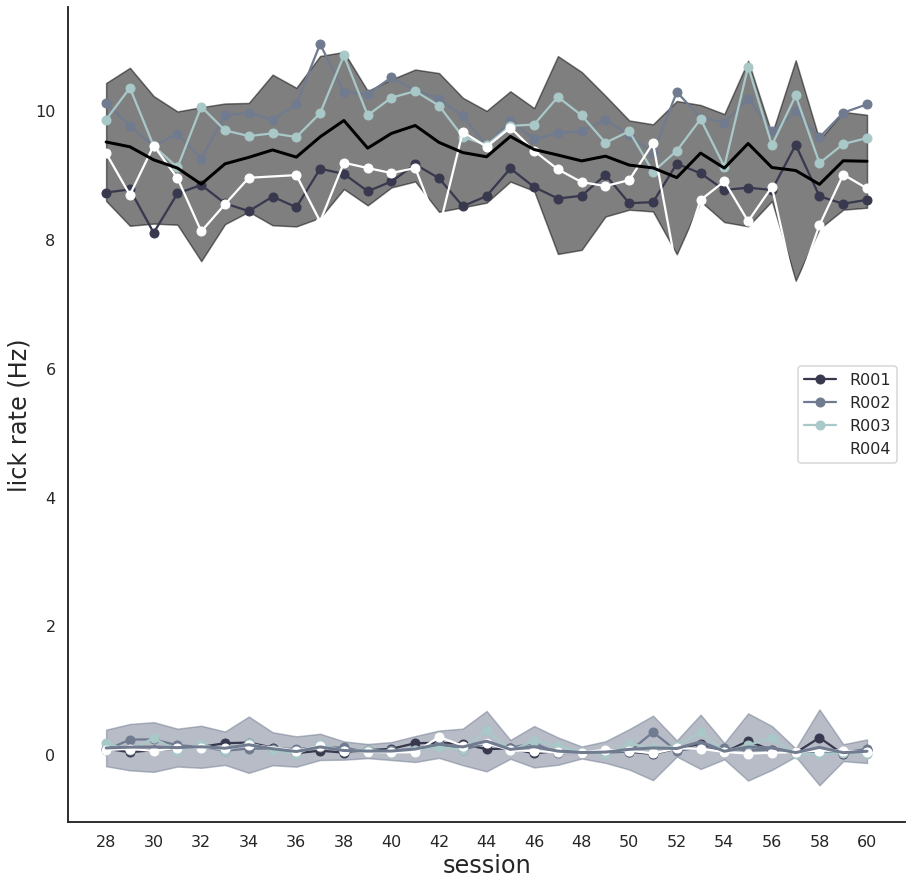

In [244]:
# Plot lick rate within and outside patch vs. day
day_range = [28, 61] # current lick sensor installed on day 28
rc_params = {'axes.titlesize': 24,
             'axes.labelsize': 24,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'legend.fontsize': 16,
             'legend.facecolor': 'inherit'}
plotter = plot.Plotter(rcParams=rc_params)
plotter.set_cmap('bone')
plotter.create_new_figure()
plotter.plot_learning_curve(days,
                            lick_stats['f_patch'],
                            day_range=day_range,
                            plot_traces=True,
                            center='mean',
                            err='std',
                            err_plot='fill',
                            c=0.0)
plotter.add_legend();
plotter.plot_learning_curve(days,
                            lick_stats['f_interpatch'],
                            day_range=day_range,
                            plot_traces=True,
                            center='mean',
                            err='std',
                            err_plot='fill',
                            c=0.5)
plotter.ax.set_xlabel('session')
plotter.ax.set_xticks(np.arange(day_range[0], day_range[-1], 2))
plotter.ax.set_ylabel('lick rate (Hz)')

upload_figure('lick_rate_vs_day.pdf', upload_folder_id, fmt='pdf')

In [245]:
# Placeholder
f_poke = {} # fraction of correct pokes

# Get stats over sessions
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)
    
    # Placeholder
    f_poke[mouse_id] = []
    
    for sess in sessions[mouse_id]:
        print('Processing session %d...' % sess.day, end=' ')
        
        try:
            t_poke, _, _ = sess._get_patch_times_from_GPIO(alternate=False)
            n_pokes = t_poke.shape[0]
            f_poke[mouse_id].append(np.array([sess.n_patches/n_pokes]))
            print('done.')
        except (UserWarning, IndexError) as w: # unanalyzable session
            print(w)
            f_poke[mouse_id].append(np.array([np.nan]))
            
    print()
    
print('Done.')

Analyzing mouse R001:
Processing session 32... done.
Processing session 12... done.
Processing session 27... done.
Processing session 35... done.
Processing session 8... done.
Processing session 9... done.
Processing session 36... done.
Processing session 15... done.
Processing session 60... done.
Processing session 44... done.
Processing session 45... done.
Processing session 21... done.
Processing session 28... done.
Processing session 10... done.
Processing session 13... done.
Processing session 5... done.
Processing session 52... done.
Processing session 47... done.
Processing session 54... done.
Processing session 31... done.
Processing session 3... done.
Processing session 18... done.
Processing session 48... done.
Processing session 39... done.
Processing session 38... done.
Processing session 58... done.
Processing session 55... done.
Processing session 16... done.
Processing session 2... index 0 is out of bounds for axis 0 with size 0
Processing session 33... done.
Processing 

100% complete...
File sucessfully uploaded.


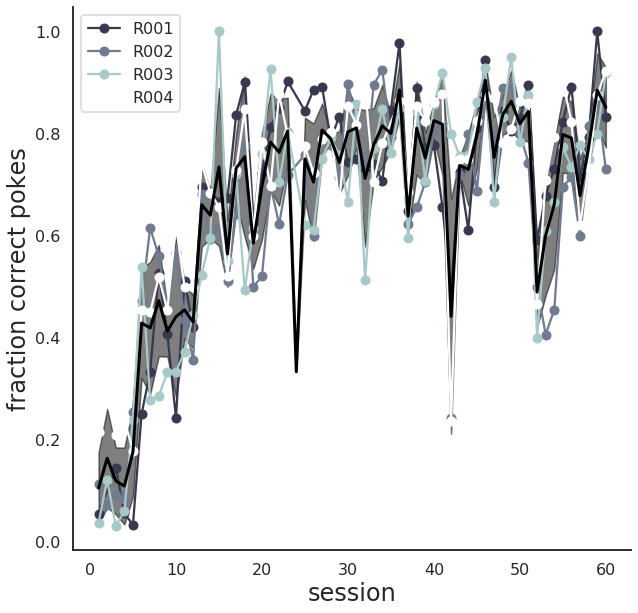

In [338]:
# Plot lick rate within and outside patch vs. day
#day_range = np.arange(1, 60)[~np.isin(np.arange(1, 60), exclude_days)]
rc_params = {'axes.titlesize': 24,
             'axes.labelsize': 24,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'legend.fontsize': 16,
             'legend.facecolor': 'inherit'}
plotter = plot.Plotter(rcParams=rc_params)
plotter.set_cmap('bone')
plotter.create_new_figure(figsize=(10, 10))
plotter.plot_learning_curve(days,
                            f_poke,
                            day_range=None,
                            plot_traces=True,
                            center='mean',
                            err='std',
                            err_plot='fill',
                            c=0.0)
plotter.add_legend()
plotter.ax.set_xlabel('session')
plotter.ax.set_ylabel('fraction correct pokes')

upload_figure('pokes_vs_day.pdf', upload_folder_id, fmt='pdf')

In [248]:
# Find binned lick counts across all animals
dt_bin = 0.100 # seconds
n_lick_reward = {}
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)
    
    n_lick_reward[mouse_id] = []
    
    for sess in sessions[mouse_id]:
        print('Processing session %02d...' % sess.day, end=' ')
        
        try:
            # Create bins
            num_bins = int(sess.analyzed_time / dt_bin)
            t_bins = np.linspace(0.0, int(sess.analyzed_time), num=num_bins)

            # Get binned lick counts across session
            t_lick = sess.get_lick_times()
            n_lick = util.in_interval(t_lick, 
                                      t_bins[:-1], 
                                      t_bins[1:], 
                                      query='interval')

            # Get binned lick counts around reward
            t_motor = sess.get_motor_times()
            if t_motor.size > 0:
                t_window, n_window = util.get_peristimulus_data(n_lick,
                                                                t_bins[:-1],
                                                                t_motor,
                                                                window=[-1.5, 1.5],
                                                                fs=1.0/dt_bin)
                n_lick_reward[mouse_id].append(n_window)
                print('done.')
            else:
                print('No rewards dispensed in session.')

        except (UserWarning, IndexError) as w: # unanalyzable session
            print(w)
            
    # Stack sessions into one array
    n_lick_reward[mouse_id] = np.vstack(n_lick_reward[mouse_id])
            
    print()

print('Done.')

Analyzing mouse R001:
Processing session 32... done.
Processing session 12... Pin labels not available for session.
Processing session 27... Licks detected simultaneously on multiple sensors.
Processing session 35... done.
Processing session 08... Pin labels not available for session.
Processing session 09... Pin labels not available for session.
Processing session 36... done.
Processing session 15... Licks detected simultaneously on multiple sensors.
Processing session 60... done.
Processing session 44... done.
Processing session 45... done.
Processing session 21... done.
Processing session 28... done.
Processing session 10... Pin labels not available for session.
Processing session 13... Pin labels not available for session.
Processing session 05... Pin labels not available for session.
Processing session 52... done.
Processing session 47... done.
Processing session 54... done.
Processing session 31... done.
Processing session 03... Pin labels not available for session.
Processing se

Processing session 44... done.
Processing session 45... done.
Processing session 21... done.
Processing session 28... done.
Processing session 10... Pin labels not available for session.
Processing session 13... Pin labels not available for session.
Processing session 05... Pin labels not available for session.
Processing session 52... done.
Processing session 47... done.
Processing session 54... done.
Processing session 31... done.
Processing session 03... Pin labels not available for session.
Processing session 18... done.
Processing session 48... done.
Processing session 39... done.
Processing session 30... done.
Processing session 38... done.
Processing session 58... done.
Processing session 55... done.
Processing session 16... Licks detected simultaneously on multiple sensors.
Processing session 02... Pin labels not available for session.
Processing session 33... done.
Processing session 26... Licks detected simultaneously on multiple sensors.
Processing session 17... done.
Proces

100% complete...
File sucessfully uploaded.


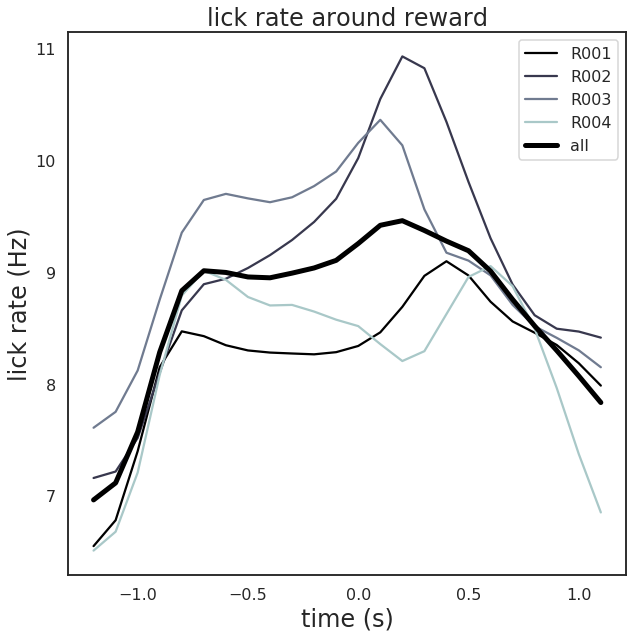

In [337]:
# Method 1: apply smoothing to summed data (but what then is standard deviation?)
rows = 1
cols = 1
fig, ax = plt.subplots(rows, cols, figsize=(10*cols, 10*rows))

for i, mouse_id in enumerate(mouse_ids):
    # Smooth lick rate
    n_lick = ephys.smooth_spike_counts(counts=np.sum(n_lick_reward[mouse_id], axis=0),
                                       dt_bin=dt_bin,
                                       method='kernel',
                                       kernel_type='Gaussian',
                                       sigma=dt_bin)
    f_lick = n_lick / dt_bin / n_lick_reward[mouse_id].shape[0]
    ax.plot(t_window[3:-3], 
            f_lick[3:-3], 
            label=mouse_id,
            color=cmap((i)/len(mouse_ids)))
    
# All animals
n_lick_all = np.vstack([n_lick for mouse_id, n_lick in n_lick_reward.items()])
n_lick = ephys.smooth_spike_counts(counts=np.sum(n_lick_all, axis=0),
                                   dt_bin=dt_bin,
                                   method='kernel',
                                   kernel_type='Gaussian',
                                   sigma=dt_bin)
f_lick = n_lick / dt_bin / n_lick_all.shape[0]
ax.plot(t_window[3:-3], 
        f_lick[3:-3],
        label='all',
        color=cmap(0.0),
        linewidth=5)

# Plot settings
ax.set_title('lick rate around reward')
ax.set_xlabel('time (s)')
ax.set_ylabel('lick rate (Hz)')
ax.legend()

upload_figure('lick_rate_reward.pdf', upload_folder_id, fmt='pdf')

Keep in mind that the sound starts 150 ms before the reward is dispensed (which itself probably takes another 200 ms to come out the lick spout). While the lick rate may increase slightly before the motor is activated (at t=0) and before the drop is realized (at t ~ 0.2), it's not convincing that they are licking in response to sound because 1) the lick rate is already very high prior to the sound cue or reward and 2) the increase is small, not significant until the drop is actually realized.

100% complete...
File sucessfully uploaded.


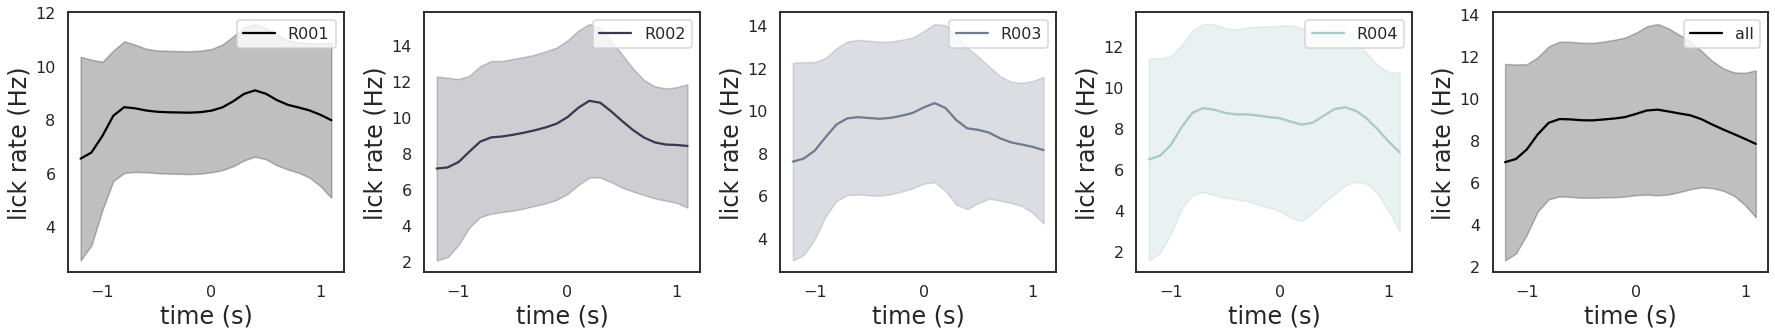

In [250]:
# Method 2: apply smoothing to each trial (mean, std based on per trial stats)
rows = 1
cols = len(mouse_ids) + 1
fig, ax = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

for i, mouse_id in enumerate(mouse_ids):
    # Smooth per trial lick rate
    n_lick = ephys.smooth_spike_counts(counts=n_lick_reward[mouse_id],
                                       dt_bin=dt_bin,
                                       method='kernel',
                                       kernel_type='Gaussian',
                                       sigma=dt_bin,
                                       axis=1)
    f_lick = n_lick / dt_bin
    mean = np.mean(f_lick, axis=0)
    std = np.std(f_lick, axis=0)
    ax[i].plot(t_window[3:-3], 
               mean[3:-3],
               color=cmap(i/len(mouse_ids)),
               label=mouse_id)
    ax[i].fill_between(t_window[3:-3], 
                       y1=mean[3:-3]-std[3:-3],
                       y2=mean[3:-3]+std[3:-3],
                       color=cmap(i/len(mouse_ids)),
                       alpha=0.25)
    
# All animals
n_lick_all = np.vstack([n_lick for mouse_id, n_lick in n_lick_reward.items()])
n_lick = ephys.smooth_spike_counts(counts=n_lick_all,
                                   dt_bin=dt_bin,
                                   method='kernel',
                                   kernel_type='Gaussian',
                                   sigma=dt_bin)
f_lick = n_lick / dt_bin 
mean = np.mean(f_lick, axis=0)
std = np.std(f_lick, axis=0)
ax[-1].plot(t_window[3:-3], 
            mean[3:-3],
            color=cmap(0.0),
            label='all')
ax[-1].fill_between(t_window[3:-3], 
                   y1=mean[3:-3]-std[3:-3],
                   y2=mean[3:-3]+std[3:-3],
                   color=cmap(0.0),
                   alpha=0.25)

# Plot settings
for ax_ in ax:
    #ax_.set_title('lick rate around reward')
    ax_.set_xlabel('time (s)')
    ax_.set_ylabel('lick rate (Hz)')
    ax_.legend()
    
plt.tight_layout()

upload_figure('lick_rate_reward_2.pdf', upload_folder_id, fmt='pdf')

#### Leaving decisions
Are the animals leaving randomly within a patch, or are they timing their decisions shortly after some reward?

We could generate two plots per condition: at leaving time, how long ago was last reward, and how long until next reward?

In [251]:
# Find time from leaving to previous/next reward
dt_reward_prev = {}
dt_reward_next = {}
n_reward = {}
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)
    
    dt_reward_prev[mouse_id] = []
    dt_reward_next[mouse_id] = []
    n_reward[mouse_id] = []
    
    for sess in sessions[mouse_id]:
        print('Processing session %02d...' % sess.day, end=' ')
        
        try:
            # Get patch-leaving and motor times
            #t_leave = sess.get_patch_times()[:, 1]
            #t_motor = sess.get_motor_times()

            # Find time from last reward to leaving
            #dt = t_leave[:, np.newaxis] - t_motor[np.newaxis, :]
            #idx_leave = np.argwhere(dt > 0) # all indices where leaving after reward
            #idx_leave = idx_leave[np.unique(idx_leave[:, 0], return_index=True)[1]] # leaving after most recent reward
            #dt_leave[mouse_id].append(dt[idx_leave[:, 0], idx_leave[:, 1]]) # time to leaving after most recent reward
            
            # Find time from last reward when leaving
            dt_reward_prev_ = analysis.get_exit_stats(sess, per_patch=True)[1]
            dt_reward_prev[mouse_id].append(dt_reward_prev_)
            
            # Calculate number of rewards per patch
            _, r_patch, _ = sess.get_harvest_rate(metric='observed', per_patch=True, return_all=True)
            n_patch = (r_patch/sess.REWARD_VOLUME).astype(np.float64) # number of rewards per patch
            n_reward[mouse_id].append(n_patch)
            
            # Find time to next reward when leaving
            t_reward = sess.calculate_reward_times()
            dt_reward = np.diff(np.append(np.insert(t_reward, 0, 0.0), np.nan)) # time between rewards
            n_patch = n_patch[n_patch > 0].astype(np.int64) # drop patches with no rewards (as above)
            dt_reward_next[mouse_id].append(dt_reward[n_patch] - dt_reward_prev_) # time to next reward
            
            print('done.')

        except (UserWarning, IndexError, KeyError) as w: # unanalyzable session
            if w == 'Reward': # no reward decay
                print('Reward decay not specified.')
            else:
                print(w)
            dt_reward_prev[mouse_id].append(np.array([np.nan]))
            dt_reward_next[mouse_id].append(np.array([np.nan]))
            n_reward[mouse_id].append(np.array([np.nan]))
            
    print()
    
print('Done.')

Analyzing mouse R001:
Processing session 32... Found threshold of 0.18 seconds.
done.
Processing session 12... Pin labels not available for session.
Processing session 27... Licks detected simultaneously on multiple sensors.
Processing session 35... Found threshold of 0.18 seconds.
done.
Processing session 08... Pin labels not available for session.
Processing session 09... Pin labels not available for session.
Processing session 36... Found threshold of 0.18 seconds.
done.
Processing session 15... Licks detected simultaneously on multiple sensors.
Processing session 60... Found threshold of 0.18 seconds.
done.
Processing session 44... Found threshold of 0.18 seconds.
done.
Processing session 45... Found threshold of 0.18 seconds.
done.
Processing session 21... Found threshold of 0.18 seconds.
done.
Processing session 28... Found threshold of 0.18 seconds.
done.
Processing session 10... Pin labels not available for session.
Processing session 13... Pin labels not available for session.

done.
Processing session 20... Found threshold of 0.18 seconds.
done.
Processing session 30... Found threshold of 0.18 seconds.
done.
Processing session 59... Found threshold of 0.28 seconds.
done.
Processing session 29... Found threshold of 0.23 seconds.
done.
Processing session 24... Found threshold of 0.23 seconds.
done.
Processing session 14... Pin labels not available for session.
Processing session 04... Pin labels not available for session.
Processing session 07... Pin labels not available for session.
Processing session 49... Found threshold of 0.28 seconds.
done.
Processing session 51... Found threshold of 0.23 seconds.
done.
Processing session 23... Found threshold of 0.18 seconds.
done.
Processing session 57... Found threshold of 0.33 seconds.
done.
Processing session 43... Found threshold of 0.28 seconds.
done.
Processing session 01... Pin labels not available for session.
Processing session 06... Pin labels not available for session.
Processing session 56... Found threshol

100% complete...
File sucessfully uploaded.


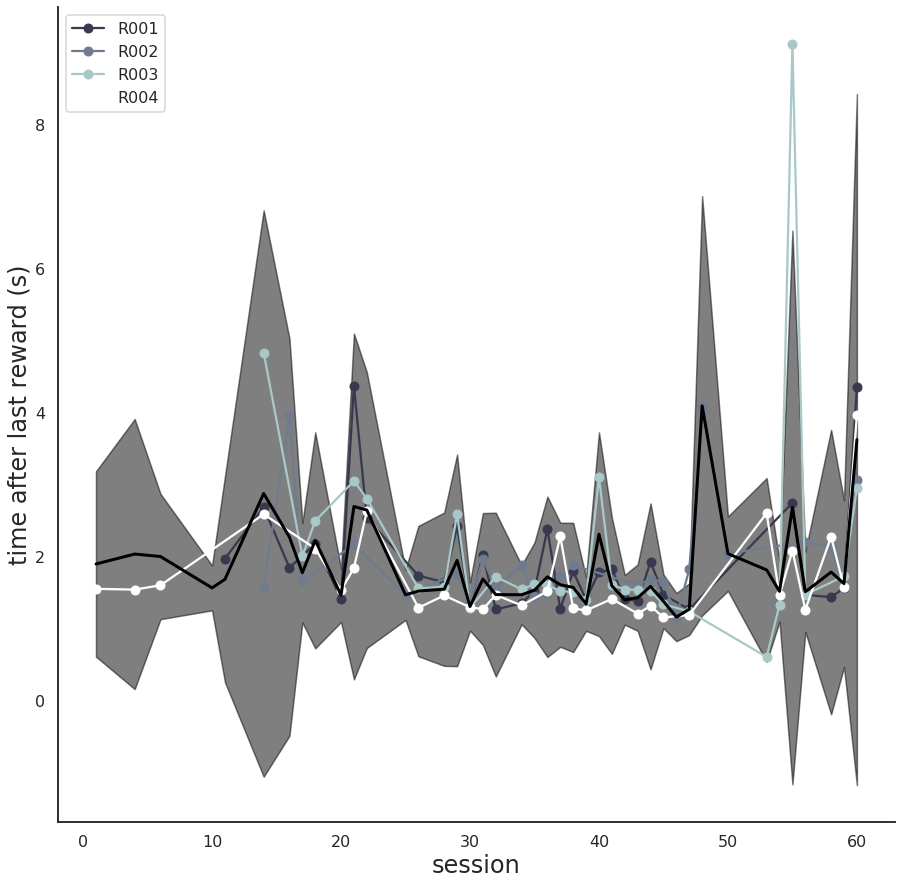

In [252]:
# Plot leaving time relative to previous/next reward vs. day
#day_range = np.arange(1, 60)[~np.isin(np.arange(1, 60), exclude_days)]
rc_params = {'axes.titlesize': 24,
             'axes.labelsize': 24,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'legend.fontsize': 16,
             'legend.facecolor': 'inherit'}
plotter = plot.Plotter(rcParams=rc_params)
plotter.set_cmap('bone')
plotter.create_new_figure()
plotter.plot_learning_curve(days,
                            dt_reward_prev,
                            day_range=include_days,
                            plot_traces=True,
                            center='mean',
                            err='std',
                            err_plot='fill',
                            c=0.0)
plotter.add_legend()
plotter.ax.set_xlabel('session')
plotter.ax.set_ylabel('time after last reward (s)')

upload_figure('time_last_reward_vs_day.pdf', upload_folder_id, fmt='pdf')

100% complete...
File sucessfully uploaded.


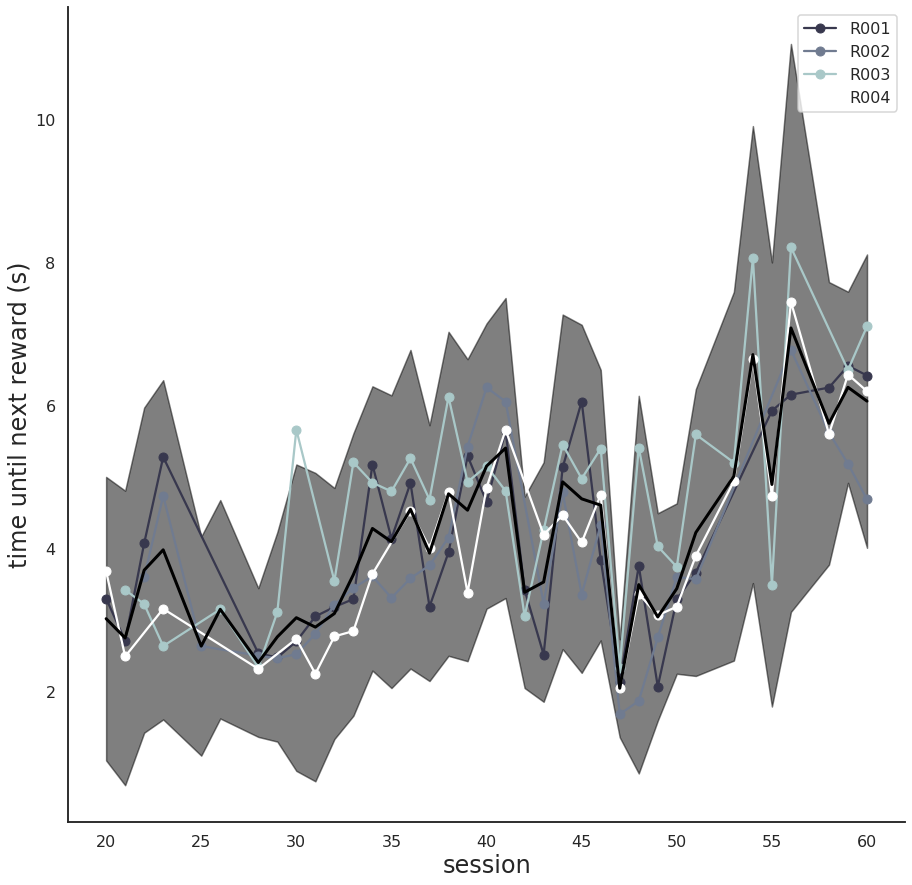

In [253]:
# Plot leaving time relative to previous/next reward vs. day
#day_range = np.arange(1, 60)[~np.isin(np.arange(1, 60), exclude_days)]
rc_params = {'axes.titlesize': 24,
             'axes.labelsize': 24,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'legend.fontsize': 16,
             'legend.facecolor': 'inherit'}
plotter = plot.Plotter(rcParams=rc_params)
plotter.set_cmap('bone')
plotter.create_new_figure()
plotter.plot_learning_curve(days,
                            dt_reward_next,
                            day_range=include_days,
                            plot_traces=True,
                            center='mean',
                            err='std',
                            err_plot='fill',
                            c=0.0)
plotter.add_legend()
plotter.ax.set_xlabel('session')
plotter.ax.set_ylabel('time until next reward (s)')

upload_figure('time_next_reward_vs_day.pdf', upload_folder_id, fmt='pdf')

100% complete...
File sucessfully uploaded.


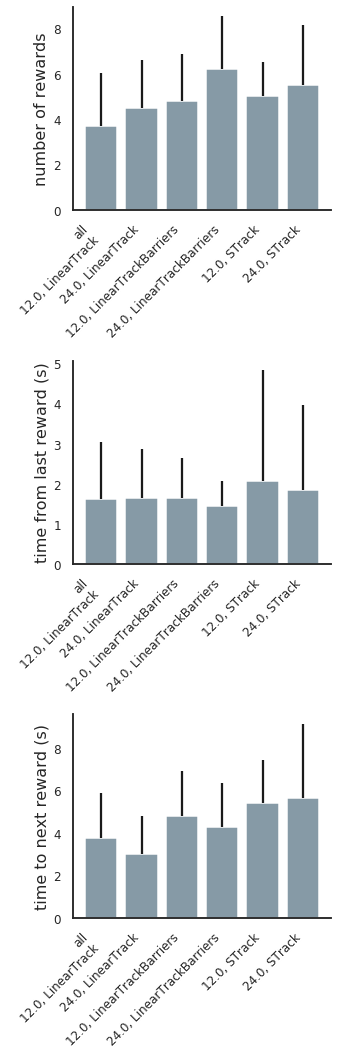

In [314]:
# Plot settings
rc_params = {'axes.titlesize': 16,
             'axes.labelsize': 16,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'legend.fontsize': 12,
             'legend.facecolor': 'inherit',
             'errorbar.capsize': 0.0}
plotter = plot.Plotter(rcParams=rc_params)
plotter.set_cmap('bone')
plotter.create_new_figure(rows=3, cols=1, figsize=(5, 15))
exclude_cond = [1]

for i, d in enumerate([n_reward, dt_reward_prev, dt_reward_next]):
    plotter.set_current_axis(i)
    plotter.bar_graph_by_condition(d, 
                                   cond, 
                                   cond_params,
                                   exclude_cond=exclude_cond,
                                   cond_order=cond_order,
                                   center='mean',
                                   err='std',
                                   c=0.6,
                                   new_fig=False,
                                   plot_subjects=False)    
    
# Plot settings
plotter.axes[0].set_ylabel('number of rewards')  
plotter.axes[1].set_ylabel('time from last reward (s)') 
plotter.axes[2].set_ylabel('time to next reward (s)') 
plt.tight_layout()

upload_figure('exit_stats_by_condition_2.pdf', upload_folder_id, fmt='pdf')

### Inclusion criteria
Filter residence and travel times based on inclusion criteria.

#### Get experimental conditions

In [96]:
# Get conditions of all travel times across all sessions
data = {}
cond_ = {}
for mouse_id in mouse_ids:
    data[mouse_id], cond_[mouse_id] = \
        util.get_patch_statistics(t_t_obs[mouse_id],
                                  ids=cond[mouse_id],
                                  return_all=True)

In [97]:
# Placeholder for inclusion indices
idx_include = {}

#### Distribution models

In [30]:
# For each set of conditions, create a new model distribution
linear_normal = {}
log_normal = {}
exp = {}
for mouse_id in mouse_ids:
    print('Mouse {}:'.format(mouse_id))
    
    linear_normal[mouse_id] = {}
    log_normal[mouse_id] = {}
    exp[mouse_id] = {}
    for cond_i in np.unique(cond_[mouse_id]):
        print('tau = {:2f}, task = {}:'.format(*cond_params[cond_i]))

        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()

        # Fit linear normal model
        model = ephys.Gaussian()
        model.fit(data[mouse_id][idx])
        mu = model.params['mu']
        std = model.params['sigma']
        p = model.goodness_of_fit(data[mouse_id][idx], method='SW').pvalue
        print('Linear-normal: mu={:2f}, std={:2f}, p={:5e}'.format(mu, std, p))
        linear_normal[mouse_id][cond_i] = model

        # Fit log normal model
        model = ephys.LogGaussian()
        model.fit(data[mouse_id][idx])
        mu = model.params['mu']
        std = model.params['sigma']
        p = model.goodness_of_fit(data[mouse_id][idx], method='SW').pvalue
        print('Log-normal: mu={:2f}, std={:2f}, p={:5e}'.format(mu, std, p))
        log_normal[mouse_id][cond_i] = model

        # Fit exponential model
        model = ephys.Exponential()
        model.fit(data[mouse_id][idx])
        lam = model.params['lam']
        p = model.goodness_of_fit(data[mouse_id][idx]).pvalue
        print('Exponential: lambda={:2f}, p={:5e}'.format(lam, p))
        exp[mouse_id][cond_i] = model

        print()
    print()

Mouse R001:
tau = 12.000000, task = LinearTrack:
Linear-normal: mu=24.498226, std=52.517174, p=1.795653e-34
Log-normal: mu=2.381470, std=1.094610, p=5.003618e-15
Exponential: lambda=0.040819, p=2.971065e-23

tau = -1.000000, task = LinearTrack:
Linear-normal: mu=73.299365, std=116.519696, p=1.613461e-25
Log-normal: mu=3.396529, std=1.351686, p=1.926464e-05
Exponential: lambda=0.013643, p=1.949076e-10

tau = 24.000000, task = LinearTrack:
Linear-normal: mu=34.074332, std=55.194152, p=1.020297e-29
Log-normal: mu=2.759390, std=1.152900, p=2.176287e-12
Exponential: lambda=0.029348, p=1.149558e-19

tau = 24.000000, task = LinearTrackBarriers:
Linear-normal: mu=41.360648, std=37.141178, p=1.273625e-11
Log-normal: mu=3.342082, std=0.885420, p=2.785386e-03
Exponential: lambda=0.024178, p=9.808373e-03

tau = 12.000000, task = LinearTrackBarriers:
Linear-normal: mu=33.199713, std=34.516101, p=3.905321e-17
Log-normal: mu=3.099702, std=0.887822, p=6.882601e-04
Exponential: lambda=0.030121, p=2.160

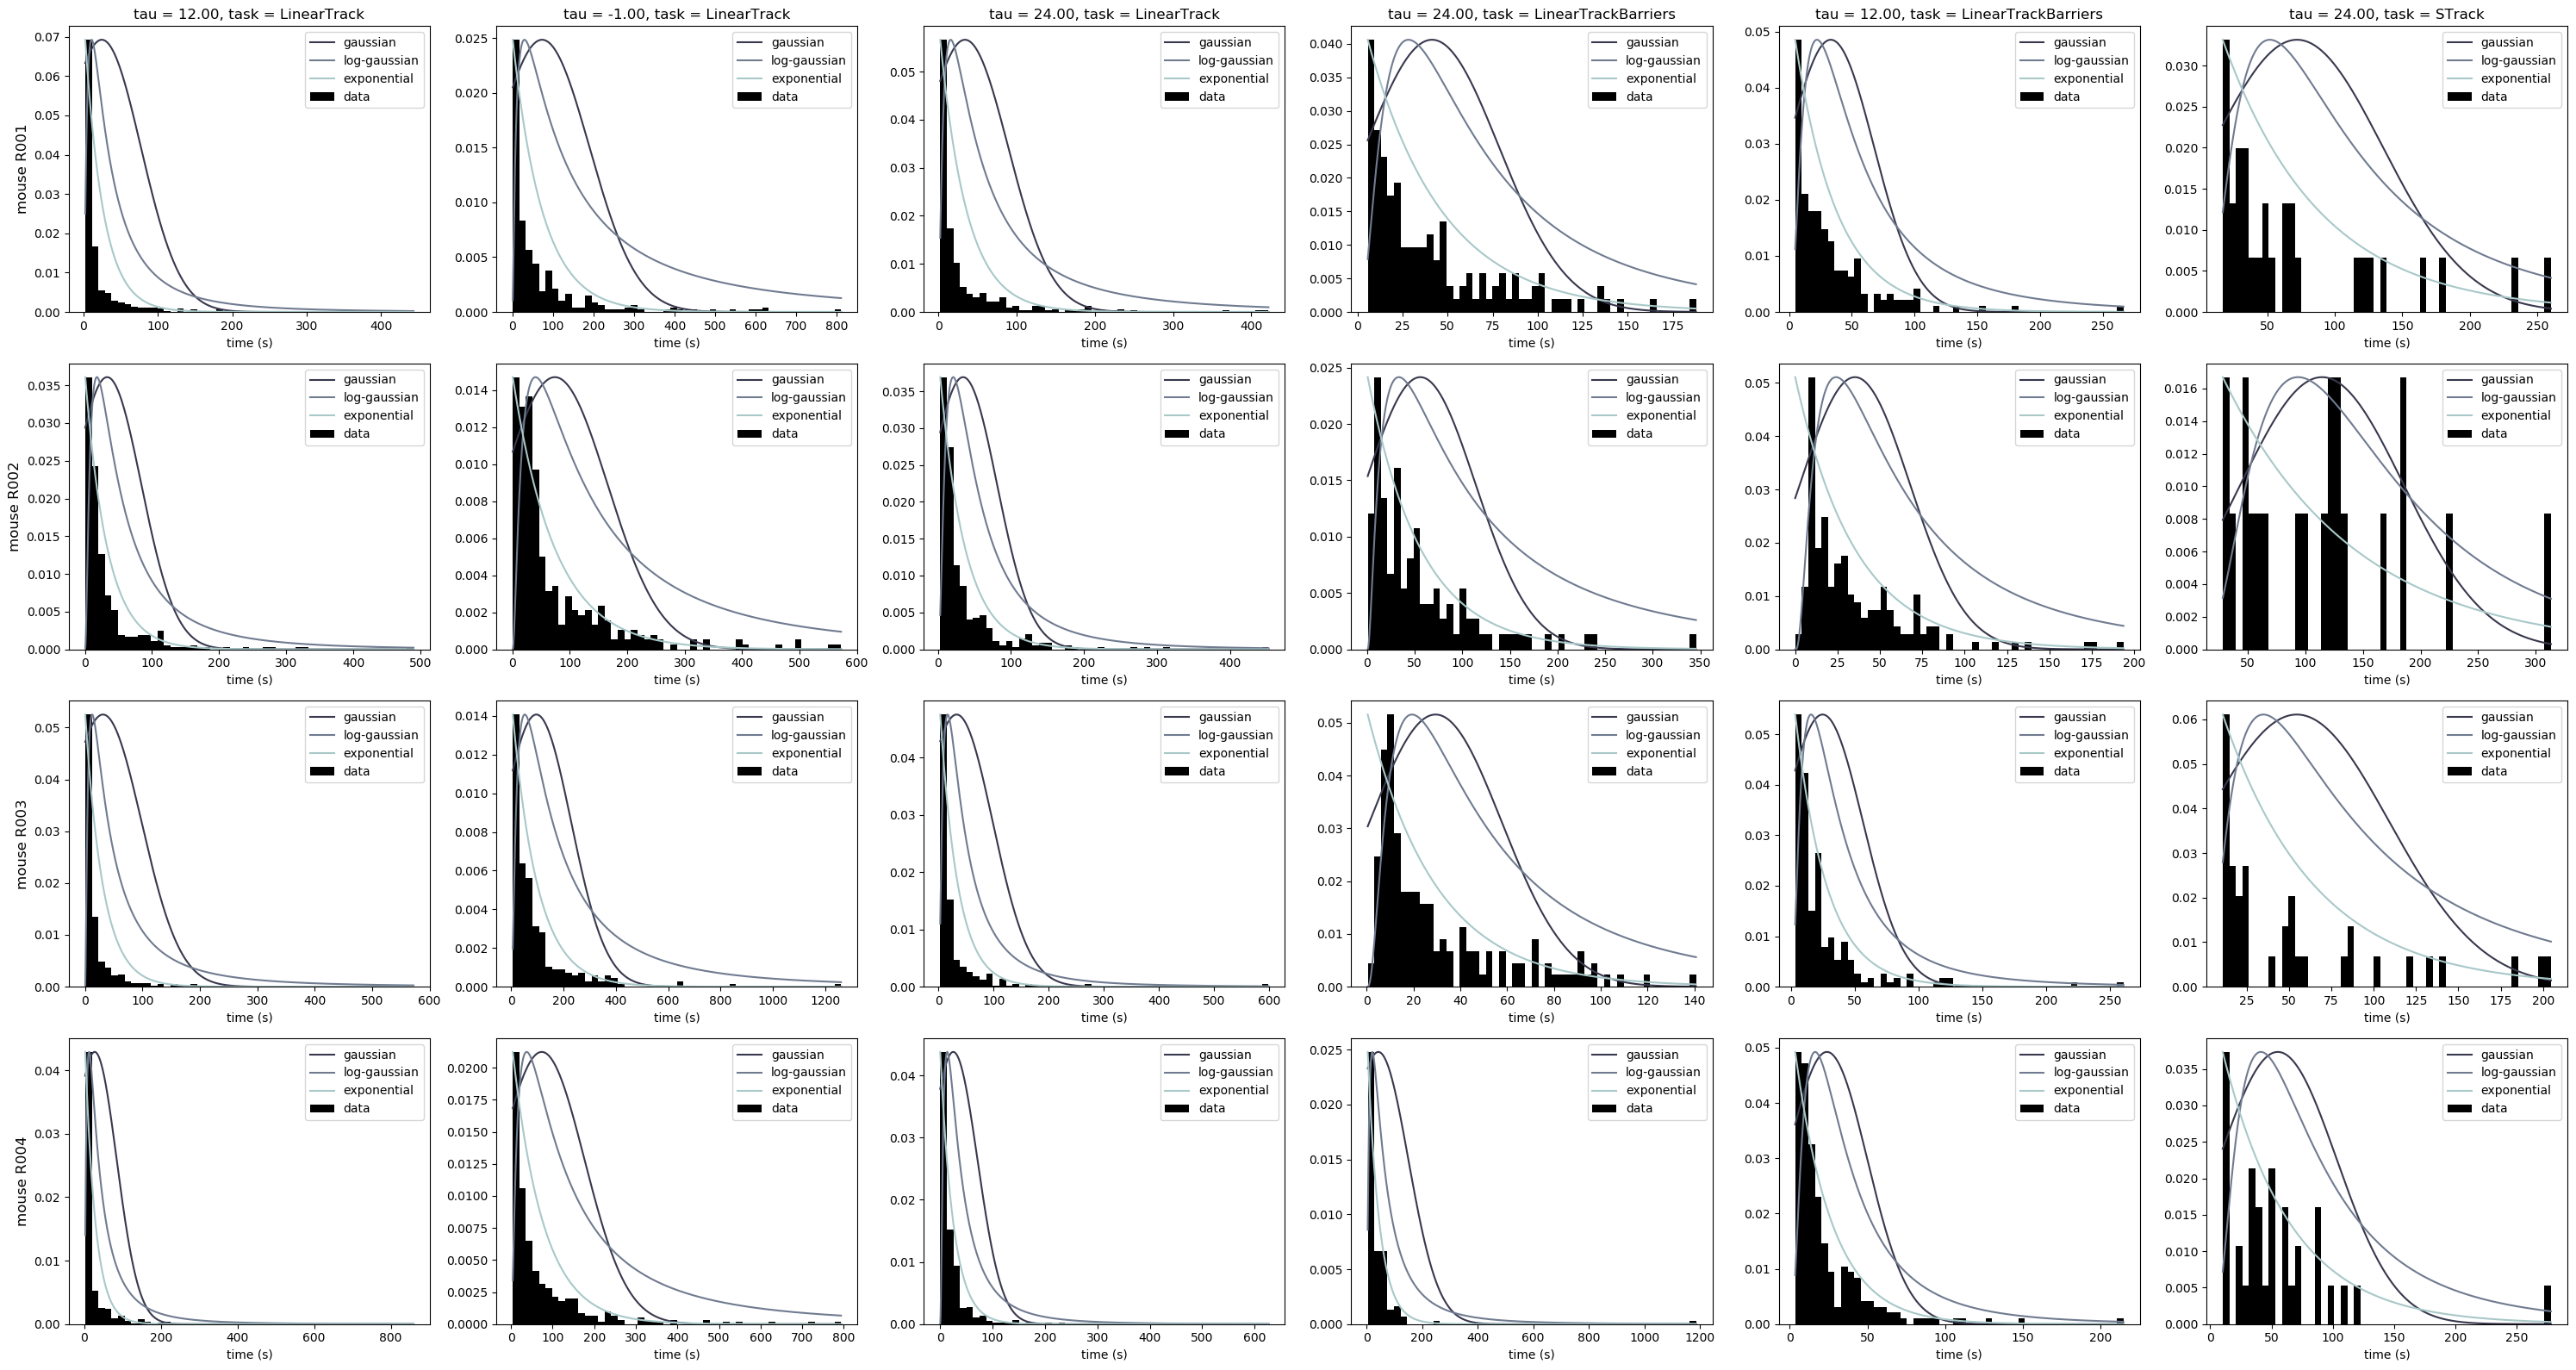

In [31]:
# Plot fits
mpl.rcdefaults() 
ncols = len(cond_params) # number of conditions
nrows = len(mouse_ids)
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
for i, mouse_id in enumerate(mouse_ids):
    for j, cond_i in enumerate(np.unique(cond_[mouse_id])):
        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()

        # Plot histogram
        ax_ = ax[i, j]
        vals, bins, _ = ax_.hist(data[mouse_id][idx], 
                                 bins=50,
                                 color=cmap(0.0), 
                                 density=True,
                                 label='data')

        # Plot model fits
        t = np.linspace(data[mouse_id][idx].min(), data[mouse_id][idx].max(), 1000)
        for k, model in enumerate([linear_normal[mouse_id][cond_i], 
                                   log_normal[mouse_id][cond_i], 
                                   exp[mouse_id][cond_i]]):
            pdf = model.pdf(t)
            scale = vals.max()/pdf.max()
            ax_.plot(t, scale*pdf,
                     color=cmap(0.25*(k+1)),
                     label=model.name)

        # Format plot
        if (i == 0):
            # Column header
            ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
        if (j == 0):
            # Row header
            ax_.set_ylabel('mouse {}'.format(mouse_id), size='large')
        ax_.set_xlabel('time (s)')
        ax_.legend()
    
plt.tight_layout()

Showing models for mouse R004:


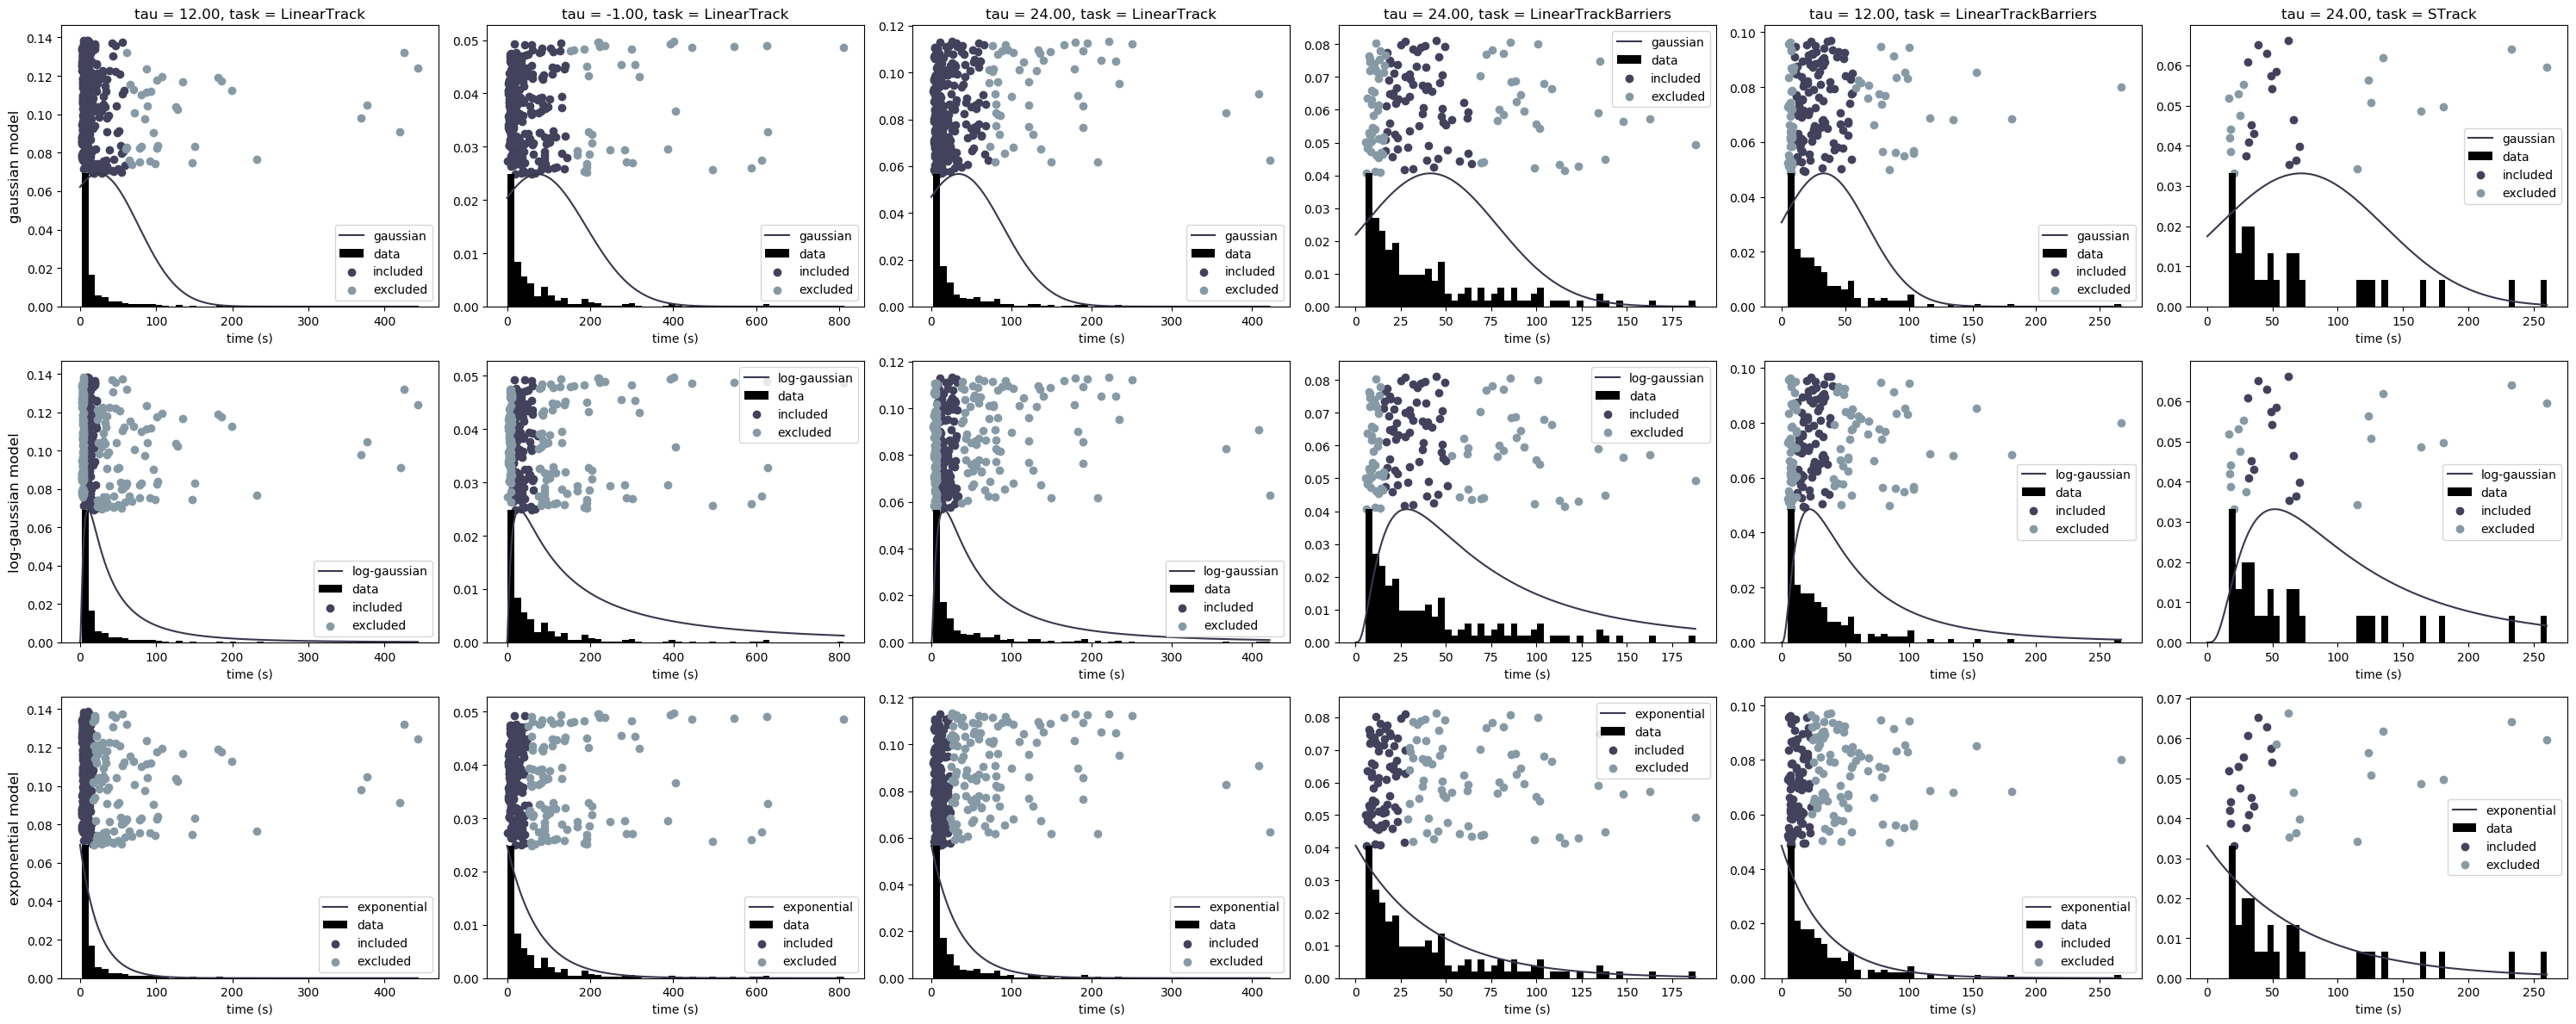

In [32]:
# Choose cutoffs
plot_id = 'R001'
mpl.rcdefaults() 
ncols = len(cond_params) # number of conditions
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
thresh = 0.50 # percentile
idx_include['percentile'] = {} # include indices

# Iterate over models
print('Showing models for mouse {}:'.format(mouse_id))
for mouse_id in mouse_ids:
    # Placeholder
    idx_include['percentile'][mouse_id] = {}
    
    for i, cond_i in enumerate(np.unique(cond_[mouse_id])):
        # Placeholder 
        idx_include['percentile'][mouse_id][cond_i] = {}
        
        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()
        t = np.linspace(0.1, data[mouse_id][idx].max(), num=1000) # for pdf

        for j, model in enumerate([linear_normal[mouse_id][cond_i], 
                                   log_normal[mouse_id][cond_i], 
                                   exp[mouse_id][cond_i]]):
            # Get indices of included times
            method = getattr(model, 'test_statistic', None)
            if method is not None and callable(method):
                idx_include_ = model.test_statistic(data[mouse_id][idx], 
                                                    distribution='f', 
                                                    test='<=', 
                                                    q=thresh)
            else:
                idx_include_ = (data[mouse_id][idx] <= model._inv_cdf(thresh))
            idx_include['percentile'][mouse_id][cond_i][model.name] = idx_include_
            
            if mouse_id == plot_id:
                # Plot histogram
                ax_ = ax[j, i]
                vals, bins, _ = ax_.hist(data[mouse_id][idx], 
                                         bins=50,
                                         color=cmap(0.0), 
                                         density=True,
                                         label='data')




                # Plot pdf
                pdf = model.pdf(t)
                scale = vals.max()/pdf.max()
                ax_.plot(t, scale*pdf,
                         color=cmap(0.25),
                         label=model.name)

                # Plot data points
                x = np.linspace(vals.max(), 2*vals.max(), num=len(data[mouse_id][idx]))
                ax_.scatter(data[mouse_id][idx][idx_include_], 
                            x[idx_include_], 
                            color=cmap(0.3), 
                            label='included')
                ax_.scatter(data[mouse_id][idx][~idx_include_], 
                            x[~idx_include_], 
                            color=cmap(0.6), 
                            label='excluded')

                # Format plot
                if (j == 0):
                    # Column header
                    ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
                if (i == 0):
                    # Row header
                    ax_.set_ylabel('{} model'.format(model.name), size='large')
                ax_.set_xlabel('time (s)')
                ax_.legend()

plt.tight_layout()

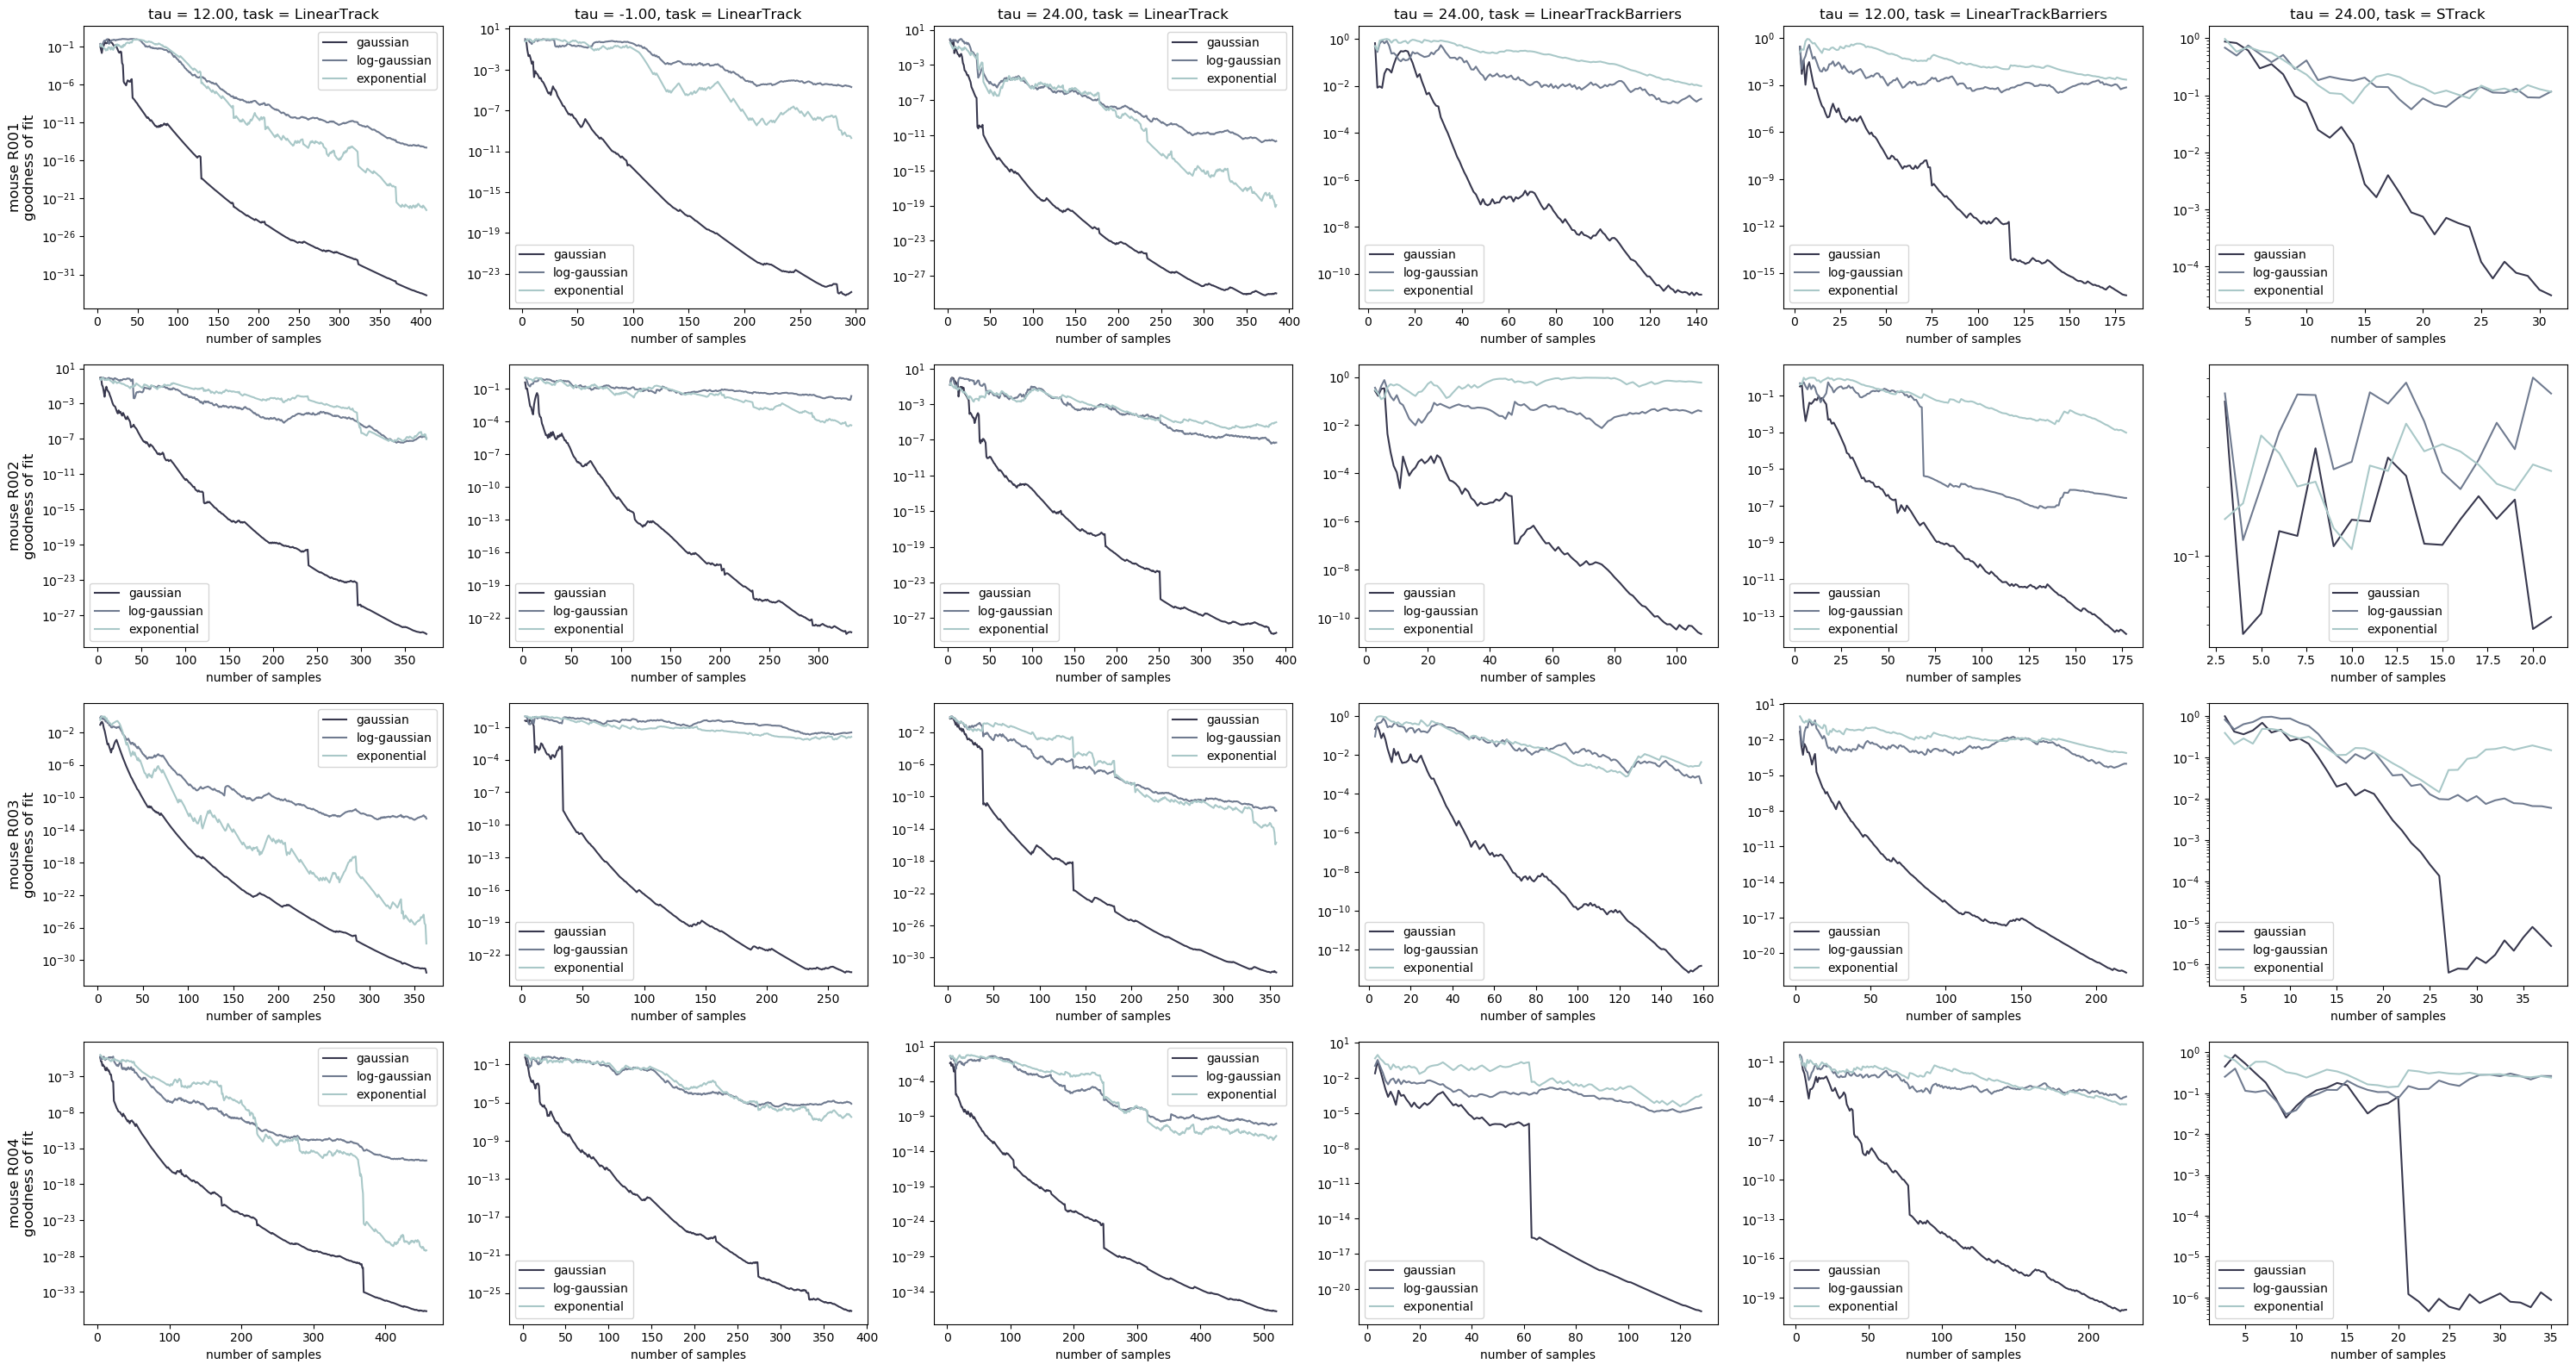

In [36]:
# Next idea: drop travel times until a best match for each distribution is found
ncols = len(cond_params) # number of conditions
nrows = len(mouse_ids) # number of animals
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
opt_samples = {}
min_data = 0.01 # minimum fraction of data to include

# Iterate over animals, models
for i, mouse_id in enumerate(mouse_ids):
    # Placeholder
    opt_samples[mouse_id] = {}
    
    for j, cond_i in enumerate(np.unique(cond_[mouse_id])):
        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()
        data_i = data[mouse_id][idx]
        
        # Placeholder
        opt_samples[mouse_id][cond_i] = {}
        
        # Axis setup
        ax_ = ax[i, j]
        n_range = np.arange(max(int(min_data*len(data_i)), 3), len(data_i)+1) # need 3 data points for SW test
        
        for k, Model in enumerate([ephys.Gaussian, ephys.LogGaussian, ephys.Exponential]):
            # Find p-values of fitting subsets of data
            model = Model()
            p = np.zeros([len(n_range)])
            for m, n in enumerate(n_range):
                model.fit(data_i[:n])
                p[m] = model.goodness_of_fit(data_i[:n]).pvalue

            # Plot p-values vs. number of samples
            ax_.plot(n_range, p, 
                     color=cmap(0.25*(k+1)),
                     label=model.name)

            # Save argmax
            opt_samples[mouse_id][cond_i][model.name] = n_range[np.argmax(p)]
        
        # Format plot
        if (i == 0):
            # Column header
            ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
        if (j == 0):
            # Row header
            ax_.set_ylabel('mouse {}\ngoodness of fit'.format(mouse_id), size='large')
        ax_.set_xlabel('number of samples')
        ax_.set_yscale('log')
        ax_.legend()     
        
plt.tight_layout()

Showing models for mouse R001:


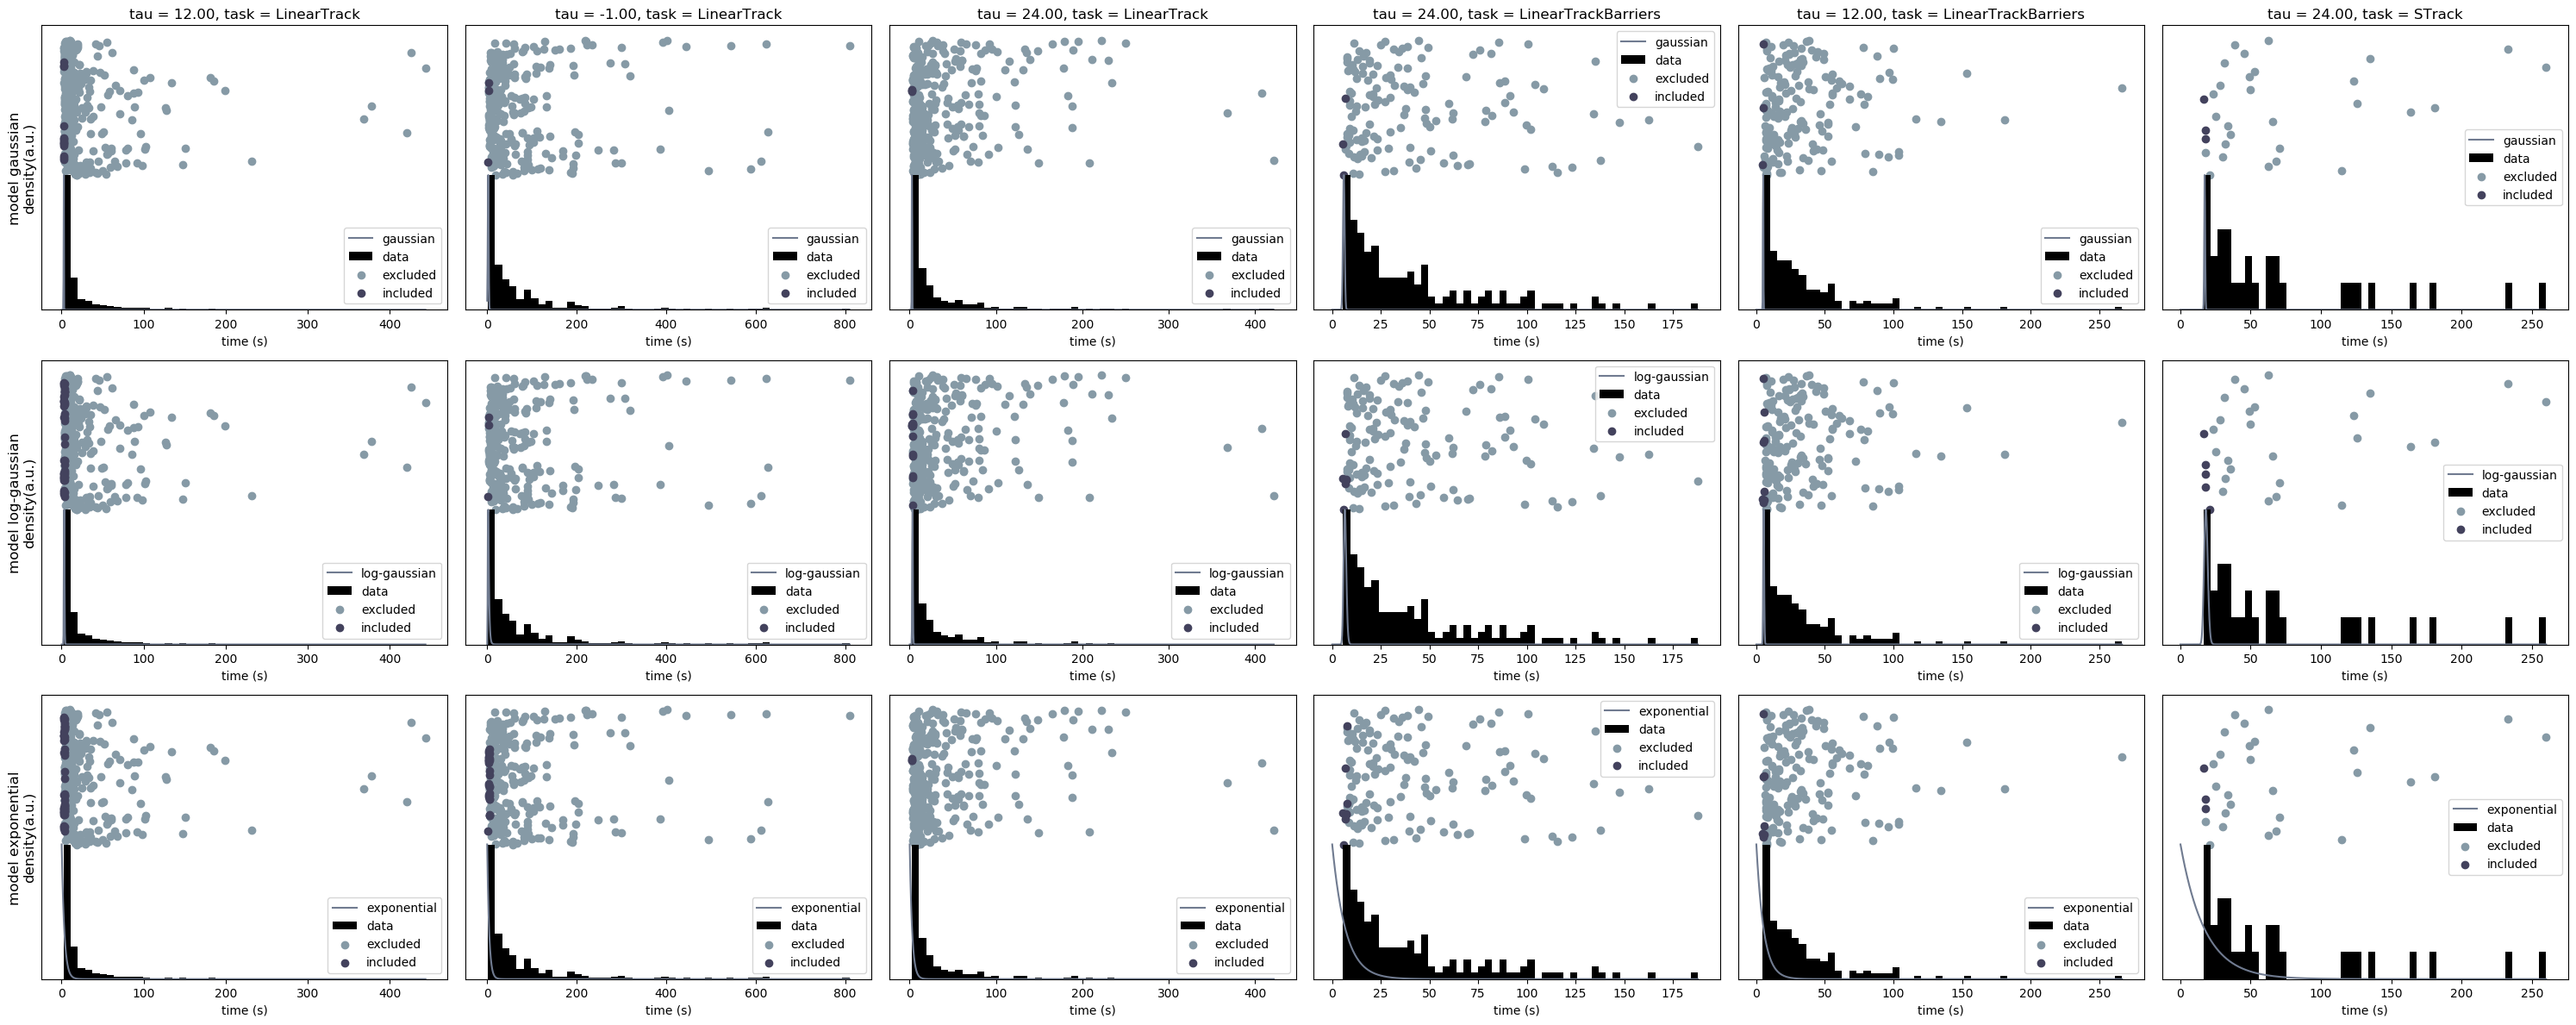

In [37]:
# Choose cutoffs by maximizing goodness of fit via above
plot_id = 'R001'
ncols = len(cond_params)
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
idx_include['samples'] = {}

# Iterate over models
print('Showing models for mouse {}:'.format(plot_id))
for mouse_id in mouse_ids:
    # Placeholder
    idx_include['samples'][mouse_id] = {}
        
    for i, cond_i in enumerate(np.unique(cond_[mouse_id])):
        # Placeholder
        idx_include['samples'][mouse_id][cond_i] = {}
        
        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()
        t = np.linspace(0.1, data[mouse_id][idx].max(), num=1000) # for pdf

        for j, Model in enumerate([ephys.Gaussian, ephys.LogGaussian, ephys.Exponential]):
            # Get indices of included times
            model = Model()
            n_samples = opt_samples[mouse_id][cond_i][model.name]
            model.fit(np.sort(data[mouse_id][idx])[:n_samples])
            idx_include_ = np.zeros(len(idx), dtype=np.bool)
            idx_include_[np.argsort(data[mouse_id][idx])[:n_samples]] = True
            idx_include['samples'][mouse_id][cond_i][model.name] = idx_include_
            
            if mouse_id == plot_id:
                # Plot histogram
                ax_ = ax[j, i]
                vals, bins, _ = ax_.hist(data[mouse_id][idx], 
                                         bins=50,
                                         color=cmap(0.0), 
                                         density=True,
                                         label='data')

                # Plot pdf
                pdf = model.pdf(t)
                scale = vals.max()/pdf.max()
                ax_.plot(t, scale*pdf,
                         color=cmap(0.50),
                         label=model.name)

                # Plot data points
                x = np.linspace(vals.max(), 2*vals.max(), num=len(data[mouse_id][idx]))
                ax_.scatter(data[mouse_id][idx][~idx_include_], 
                            x[~idx_include_], 
                            color=cmap(0.6), 
                            label='excluded')
                ax_.scatter(data[mouse_id][idx][idx_include_], 
                            x[idx_include_], 
                            color=cmap(0.3), 
                            label='included')

                # Format plot
                if (j == 0):
                    # Column header
                    ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
                if (i == 0):
                    # Row header
                    ax_.set_ylabel('model {}\ndensity(a.u.)'.format(model.name), size='large')
                ax_.set_yticks([])
                ax_.set_xlabel('time (s)')
                #ax_.set_xlim([-10, 200])
                ax_.legend()
        
plt.tight_layout()

#### Classification models

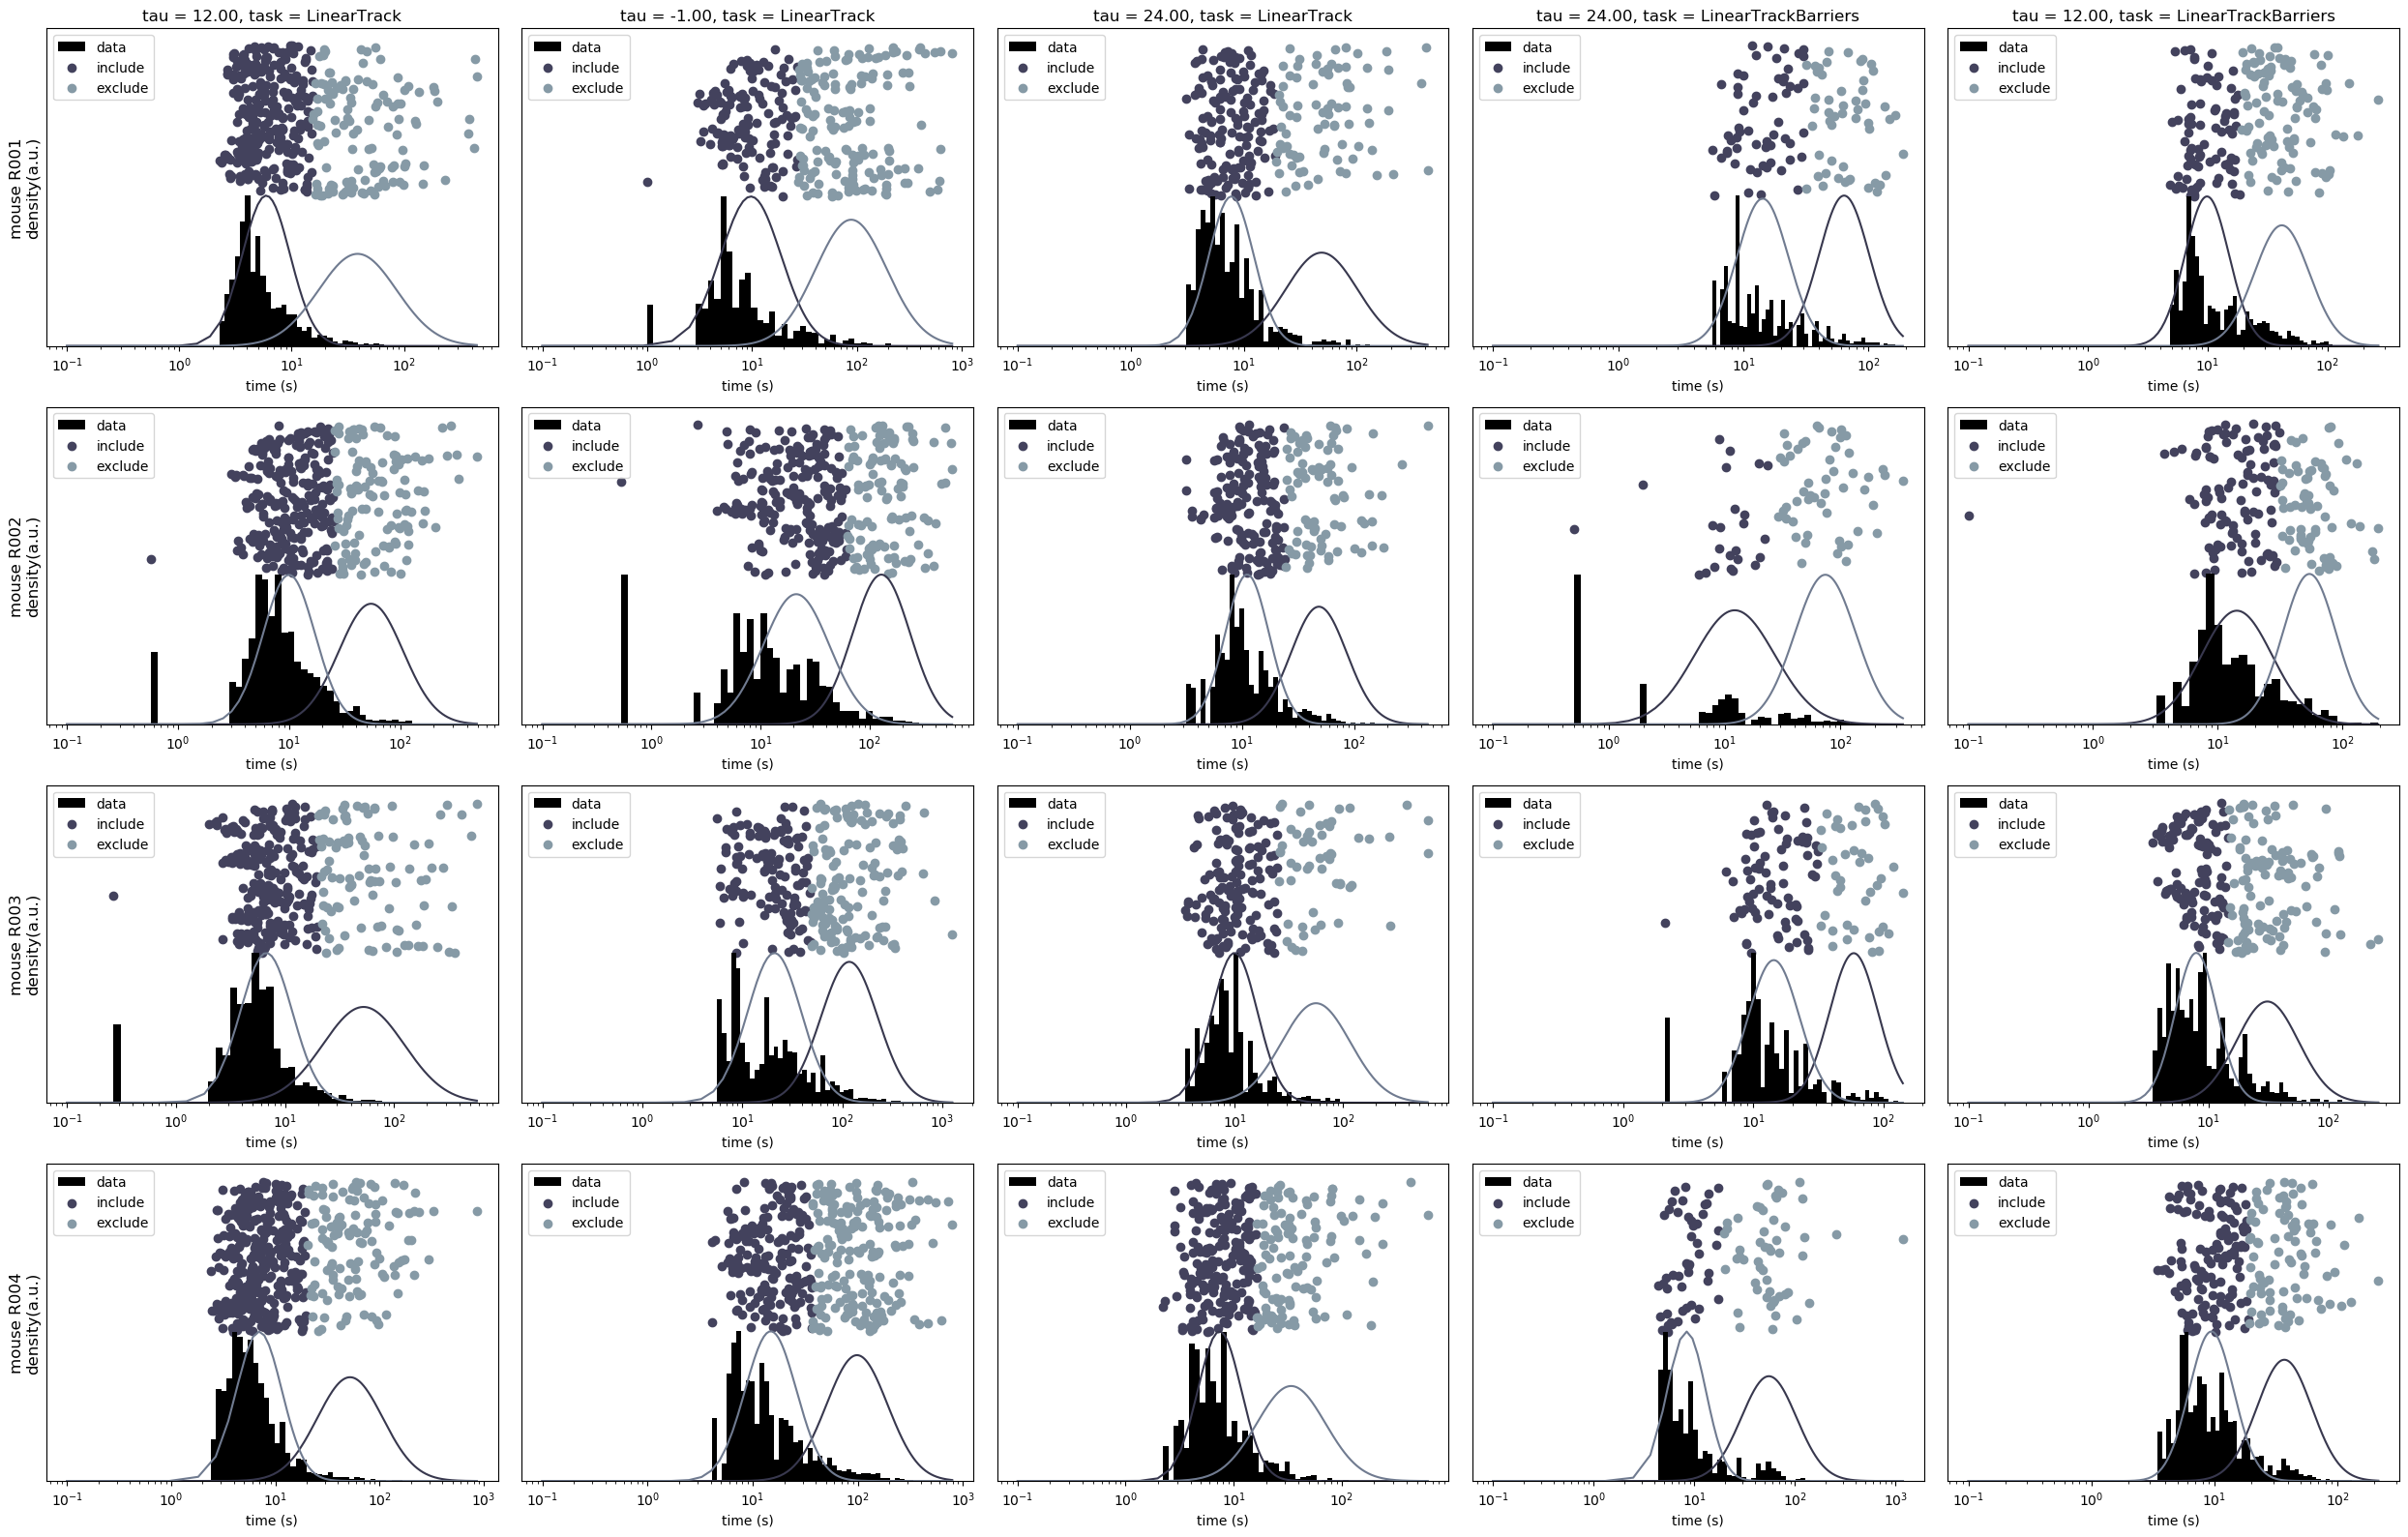

In [104]:
# Choose cutoffs by fitting to GMM with k=2
k = 2
ncols = len(cond_params)
nrows = len(mouse_ids)
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
idx_include['classification'] = {}

# Iterate over animals, models
gmm = {}
for i, mouse_id in enumerate(mouse_ids):
    # Placeholders
    idx_include['classification'][mouse_id] = {}
    gmm[mouse_id] = {}
    
    for j, cond_i in enumerate(np.unique(cond_[mouse_id])):
        # Placeholder
        idx_include['classification'][mouse_id][cond_i] = {}
        
        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()
        t = np.linspace(0.1, data[mouse_id][idx].max(), num=1000) # for pdf

        # Plot histogram
        ax_ = ax[i, j]
        vals, bins = np.histogram(data[mouse_id][idx], bins=50)
        logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), num=len(bins))
        vals, bins, _ = ax_.hist(data[mouse_id][idx], 
                                 bins=logbins,
                                 color=cmap(0.0), 
                                 density=True,
                                 label='data')
        

        # Get fit GMM
        model = ephys.GaussianMixture(k=k)
        model.fit(np.log(data[mouse_id][idx]), verbose=False)
        labels = model.predict(np.log(data[mouse_id][idx]))
        gmm[mouse_id][cond_i] = model
        
        # Get indices of included times
        label_include = np.argmin(model.params['mu'])
        idx_include_ = (labels == label_include)
        idx_include['classification'][mouse_id][cond_i][model.name] = idx_include_

        # Find maximum pdf value for scale
        max_val = 0.0
        scale = 1.0
        for k_ in range(k):
            pdf = model._models[k_].pdf(np.log(t))
            if pdf.max() > max_val:
                scale = vals.max()/pdf.max()
                max_val = pdf.max()
                
        # Plot pdf of each Gaussian in mixture
        for k_ in range(k):  
            pdf = model._models[k_].pdf(np.log(t))
            ax_.plot(t, scale*pdf,
                     color=cmap(0.25*(k_+1)))

        # Plot data points
        x = np.linspace(vals.max(), 2*vals.max(), num=len(data[mouse_id][idx]))
        ax_.scatter(data[mouse_id][idx][idx_include_], 
                    x[idx_include_], 
                    color=cmap(0.30),
                    label='include')
        ax_.scatter(data[mouse_id][idx][~idx_include_], 
                    x[~idx_include_], 
                    color=cmap(0.60),
                    label='exclude')

        # Format plot
        if (i == 0):
            # Column header
            ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
        if (j == 0):
            # Row header
            ax_.set_ylabel('mouse {}\ndensity(a.u.)'.format(mouse_id), size='large')
        ax_.set_yticks([])
        ax_.set_xlabel('time (s)')
        ax_.set_xscale('log')
        #ax_.set_xlim([-10, 200])
        ax_.legend()
        
plt.tight_layout()

#### Plot filtered data
Now let's re-plot the travel time and residence time results with filtered data. From the above plot, it looks like fitting a GMM with two components gives reasonable results.

Remember that the underlying code in `Session.get_patch_durations()` and `Session.get_interpatch_durations()` already pairs each residence time with the subsequent travel time (with the idea that residence time is informed by the anticipated subsequent travel time). Thus if we filter by travel times, we can simply use the same indices to filter the residence times, knowing that they will be matched.

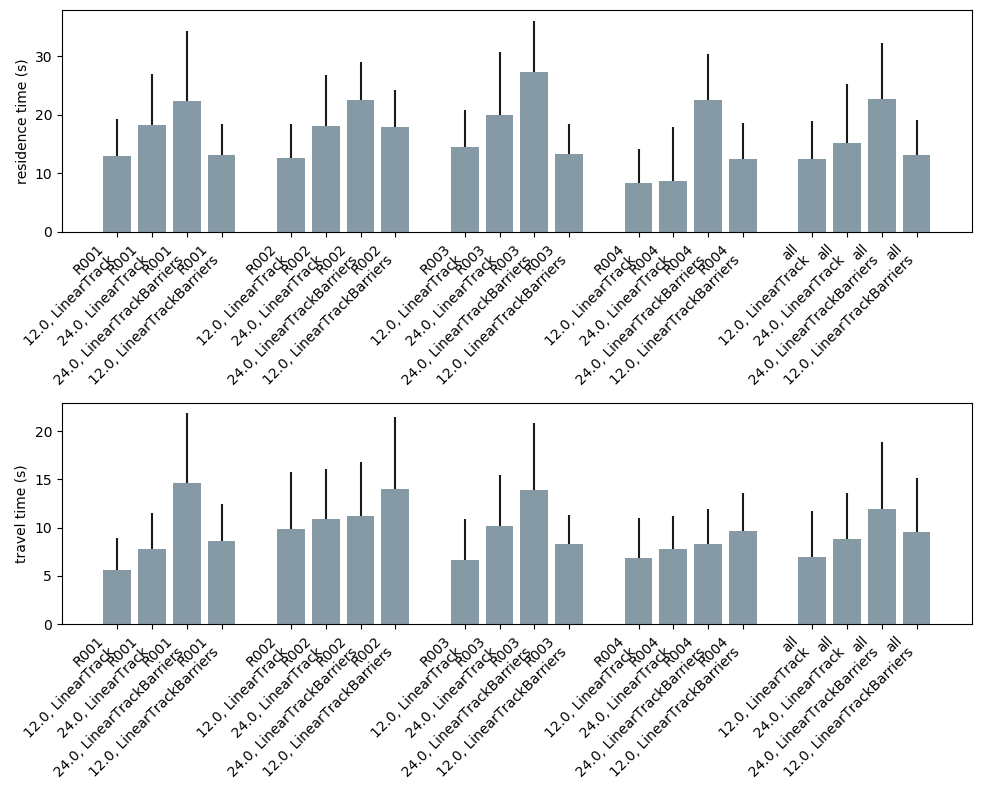

In [105]:
# Plot results
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
cmap = plt.get_cmap('bone')
filt_method = 'classification'
filt_model = 'gaussian-mixture'
exclude_cond = [1]

# Filter data by inclusion criteria
t_p_filt = {}
t_t_filt = {}
cond_filt = {}
pvalues = {}
for i, mouse_id in enumerate(mouse_ids):
    # Get data
    t_t_, cond_t = util.get_patch_statistics(t_t_obs[mouse_id],
                                            ids=cond[mouse_id],
                                            return_all=True)
    t_p_, cond_p = util.get_patch_statistics(t_p_obs[mouse_id],
                                            ids=cond[mouse_id],
                                            return_all=True)
    assert (cond_t == cond_p).all()
    
    # Iterate over experimental conditions
    t_t_filt_ = []
    t_p_filt_ = []
    cond_filt_ = []
    cond_iters = np.unique(cond_t)[~np.isin(np.unique(cond_t), exclude_cond)]
    for j, cond_i in enumerate(cond_iters):
        # Find indices
        idx = np.argwhere(cond_t == cond_i).flatten()
        
        # Get inclusion labels
        #labels = gmm[mouse_id][cond_i].predict(t_t_[idx])
        #label_include = np.argmin(gmm[mouse_id][cond_i].params['mu'])
        #idx_include = (labels == label_include)
        idx_include_ = idx_include[filt_method][mouse_id][cond_i][filt_model]
        
        # Keep only included data
        t_t_filt_.append(t_t_[idx][idx_include_])
        t_p_filt_.append(t_p_[idx][idx_include_])
        cond_filt_.append(cond_t[idx][idx_include_])
        
    # Stack data
    t_t_filt[mouse_id] = np.hstack(t_t_filt_)
    t_p_filt[mouse_id] = np.hstack(t_p_filt_)
    cond_filt[mouse_id] = np.hstack(cond_filt_)

    for j, filt_data in enumerate([t_p_filt, t_t_filt]):
        # Get patch statistics by experimental condition
        t_all, cond_all = util.get_patch_statistics(filt_data[mouse_id],
                                                    ids=cond_filt[mouse_id],
                                                    return_all=True)
        t_plot, cond_plot = util.get_patch_statistics(filt_data[mouse_id], 
                                            ids=cond_filt[mouse_id], 
                                            method='median', 
                                            return_all=False)
        t_err, cond_plot = util.get_patch_statistics(filt_data[mouse_id], 
                                            ids=cond_filt[mouse_id], 
                                            method='std', 
                                            return_all=False)
        
        # Get t-test results from all pairwise comparisons
        #pvalues[mouse_id] = {}
        #for k, cond_1 in enumerate(cond_plot[:-1]):
        #    for l, cond_2 in enumerate(cond_plot[k+1:]):
        #        idx_1 = np.argwhere(cond_all == cond_1).flatten()
        #        idx_2 = np.argwhere(cond_all == cond_2).flatten()
        #        _, pvalue = stats.ttest_rel(t_all[idx_1], t_all[idx_2])
        #        pvalues[mouse_id][cond_1][cond_2] = pvalue
        #        pvalues[mouse_id][cond_2][cond_1] = pvalue

        # Plot residence times
        x = np.arange(len(cond_plot)) + i*(len(cond_plot) + 1)
        yerr = np.vstack([np.zeros(len(t_err)), t_err])
        ax[j].bar(x, 
                  t_plot, 
                  yerr=yerr,
                  color=cmap(0.60))

        # Format axis
        if (i == 0):
            ax[j].set_xticks([]) # clear default ticks
        xticks = ax[j].get_xticks()
        ax[j].set_xticks(list(xticks) + list(x))
        xtick_labels = [label._text for label in ax[j].get_xticklabels()
                        if label._text != '']
        new_labels = ['{}\n{}, {}'.format(mouse_id, *params) for key, params in cond_params.items()
                      if key not in exclude_cond]
        ax[j].set_xticklabels(xtick_labels + new_labels)

        
for j, filt_data in enumerate([t_p_filt, t_t_filt]):
    # Get consolidated data across animals
    t_plot, cond_plot = util.get_patch_statistics(filt_data, 
                                        ids=cond_filt, 
                                        method='median', 
                                        return_all=False)
    t_err, cond_plot = util.get_patch_statistics(filt_data, 
                                        ids=cond_filt, 
                                        method='std', 
                                        return_all=False)

    # Plot consolidated residence times
    x = np.arange(len(cond_plot)) + len(mouse_ids)*(len(cond_plot) + 1)
    yerr = np.vstack([np.zeros(len(t_err)), t_err])
    ax[j].bar(x, 
              t_plot, 
              yerr=yerr,
              color=cmap(0.60))
    xticks = ax[j].get_xticks()
    ax[j].set_xticks(list(xticks) + list(x))
    xtick_labels = [label._text for label in ax[j].get_xticklabels()
                    if label._text != '']
    new_labels = ['{}\n{}, {}'.format('all', *params) for key, params in cond_params.items()
                  if key not in exclude_cond]
    ax[j].set_xticklabels(xtick_labels + new_labels, rotation=45, ha='right')

# Format axis
ax[0].set_ylabel('residence time (s)')
ax[1].set_ylabel('travel time (s)')

plt.tight_layout();

#### Correlation between residence and subsequent travel times

In [257]:
# Get stats across all animals, sessions
t_p_all, cond_all = util.get_patch_statistics(t_p_obs,
                                    ids=cond,
                                    return_all=True)
t_t_all, cond_all = util.get_patch_statistics(t_t_obs,
                                    ids=cond,
                                    return_all=True)

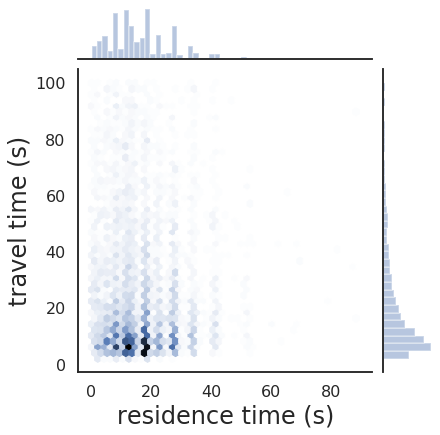

In [110]:
plot_idx = (t_t_all <= 100)
(sns.jointplot(t_p_all[plot_idx], t_t_all[plot_idx], 
              kind='hex')
    .set_axis_labels('residence time (s)', 'travel time (s)'))

100% complete...
File sucessfully uploaded.


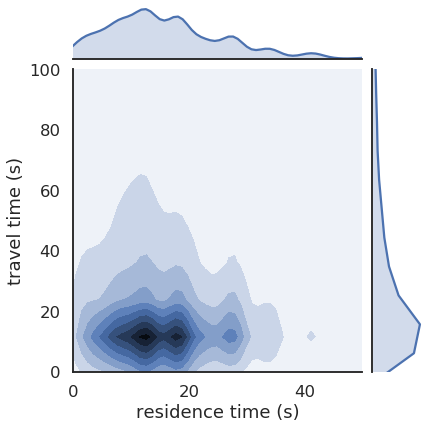

In [111]:
sns.set(context='talk', 
        style='white', 
        palette='deep', 
        rc={'figure.figsize': (20, 20)})
g = (sns.jointplot(t_p_all, 
               t_t_all, 
               kind='kde', 
               xlim=[-0.1*t_p_all.min(), 50],
               ylim=[-0.1*t_t_all.min(), 100])
    .set_axis_labels('residence time (s)', 'travel time (s)'))
#g.fig.savefig('/home/james/Desktop/test.pdf')
upload_figure('residence_time_travel_time_correlation.pdf', upload_folder_id, fmt='pdf')

100% complete...
File sucessfully uploaded.


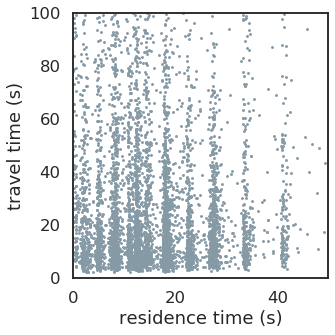

In [112]:
plot_idx = (t_t_all <= 100)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(t_p_all[plot_idx], t_t_all[plot_idx],
           color=cmap(0.6), s=2.0)
ax.set_xlabel('residence time (s)')
ax.set_ylabel('travel time (s)')
ax.set_xlim([-0.1*t_p_all.min(), 50])
ax.set_ylim([-0.1*t_t_all.min(), 100])
plt.tight_layout()

upload_figure('residence_time_travel_time_scatter.pdf', upload_folder_id, fmt='pdf')

100% complete...
File sucessfully uploaded.


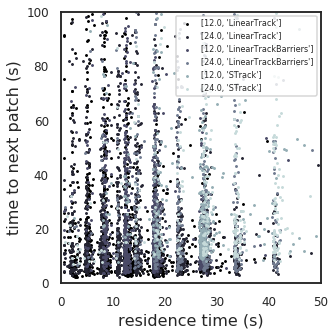

In [323]:
# Compare by condition
rc_params = {'axes.titlesize': 16,
             'axes.labelsize': 16,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'legend.fontsize': 8,
             'legend.facecolor': 'inherit'}
plotter = plot.Plotter(rcParams=rc_params)
fig, ax = plt.subplots(figsize=(5, 5))
cond_iters = np.unique(cond_all)
cond_iters = cond_iters[cond_order]
for i, cond_i in enumerate(cond_iters):
    t_t_i = t_t_all[cond_all == cond_i]
    t_p_i = t_p_all[cond_all == cond_i]

    plot_idx = (t_t_i <= 100)
    ax.scatter(t_p_i[plot_idx], 
               t_t_i[plot_idx],
               color=cmap(i/len(cond_iters)), 
               s=2.0,
               label=cond_params[cond_i])
    
ax.set_xlabel('residence time (s)')
ax.set_ylabel('time to next patch (s)')
ax.set_xlim([-0.1*t_p_all.min(), 50])
ax.set_ylim([-0.1*t_t_all.min(), 100])
ax.legend()
    
plt.tight_layout()

upload_figure('residence_time_travel_time_scatter_condition.png', upload_folder_id, fmt='png')

#### Minimum travel time
The reasoning for filtering residence times in the first place was that:
1. The current residence time is dependent on the anticipated travel time (i.e. the next travel time).
2. Long travel times are associated with task disengagement.
3. Therefore, residence times prior to long travel times should be excluded from analysis (along with the long travel times).

However, the above plots make it clear that there is no correlation between residence time and the subsequent travel time. Thus, the first premise is invalid, and there is no need to filter residence times based on subsequent travel times. Instead, we can just assign the minimum (or some function of the bottom percentile) travel time to each patch-interpatch segment, and assume the remaining travel time is "extra" stuff due to a variety of non-foraging factors (grooming, exploration, etc.). This will come in handy later when we build an internal model of the mouse during the task, but for now, we can just lump it into a "non-foraging" category while we focus on the foraging analysis.

In [260]:
t_t_min = {}
t_t_nf = {}
for mouse_id in mouse_ids:
    # Placeholder
    t_t_min[mouse_id] = {}
    t_t_nf[mouse_id] = []
    
    # Get travel time stats
    t_t_, cond_t = util.get_patch_statistics(t_t_obs[mouse_id],
                                             ids=cond[mouse_id],
                                             return_all=True)
    
    # Iterate over conditions to get travel time stats
    for cond_i in np.unique(cond[mouse_id]):
        # Get travel time stats for condition. Set to median of 
        # bottom tenth percentile of travel times.
        idx = np.argwhere(cond_i == cond_t).flatten()
        t_t_min[mouse_id][cond_i] = np.median(np.sort(t_t_[idx])[:max(len(idx)//10, 1)]) 
        
    # Iterate over sessions to get corrected travel times
    for j, cond_i in enumerate(cond[mouse_id]):
        # Question: correct for negative non-foraging times?
        t_t_nf[mouse_id].append(t_p_obs[mouse_id][j] - t_t_min[mouse_id][cond_i])

#### Plot filtered data (revisited)
We will recreate the residence and travel time vs. conditions plots with the minimum travel times.

100% complete...
File sucessfully uploaded.


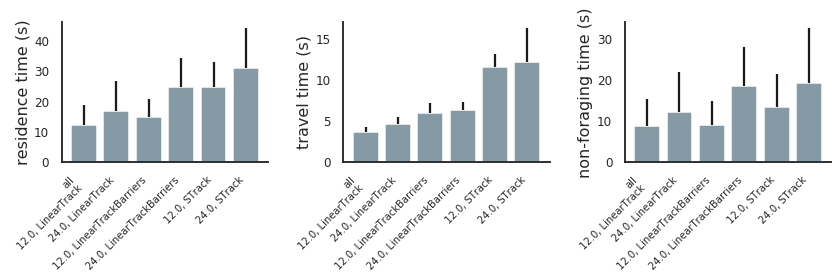

In [341]:
# Plot results
rc_params = {'axes.titlesize': 16,
             'axes.labelsize': 16,
             'xtick.labelsize': 10,
             'ytick.labelsize': 12,
             'legend.fontsize': 12,
             'legend.facecolor': 'inherit',
             'errorbar.capsize': 0.0}
cmap = plt.get_cmap('bone')
nrows = 1
ncols = 3
plotter = plot.Plotter(cmap=cmap, rcParams=rc_params)
plotter.create_new_figure(figsize=(4*ncols, 4*nrows), rows=nrows, cols=ncols)
exclude_cond = [1]

# Plot residence times
plotter.set_current_axis(0)
plotter.bar_graph_by_condition(t_p_obs, 
                               cond, 
                               cond_params,
                               exclude_cond=exclude_cond,
                               cond_order=cond_order,
                               center='mean',
                               err='std',
                               c=0.6,
                               new_fig=False,
                               plot_subjects=False)
plotter.ax.set_ylabel('residence time (s)')

# Plot minimum travel times
plotter.set_current_axis(1)
t_t_plot = {mouse_id: [t_t_min[mouse_id][cond_i] for cond_i in np.unique(cond[mouse_id])]
            for mouse_id in mouse_ids}
cond_plot = {mouse_id: list(np.unique(cond[mouse_id]))
             for mouse_id in mouse_ids}
plotter.bar_graph_by_condition(t_t_plot, 
                               cond_plot, 
                               cond_params,
                               exclude_cond=exclude_cond,
                               cond_order=cond_order,
                               center='mean',
                               err='std',
                               c=0.6,
                               new_fig=False,
                               plot_subjects=False)
plotter.ax.set_ylabel('travel time (s)')

# Plot non-foraging times
plotter.set_current_axis(2)
plotter.bar_graph_by_condition(t_t_nf, 
                               cond, 
                               cond_params,
                               exclude_cond=exclude_cond,
                               cond_order=cond_order,
                               center='mean',
                               err='std',
                               c=0.6,
                               new_fig=False,
                               plot_subjects=False)
plotter.ax.set_ylabel('non-foraging time (s)')

# Format plot
plt.tight_layout()

upload_figure('residence_travel_time_vs_condition_all.pdf', upload_folder_id, fmt='pdf')

In [425]:
cond_params

{0: [12.0, 'LinearTrack'],
 1: [-1, 'LinearTrack'],
 2: [24.0, 'LinearTrack'],
 3: [12.0, 'STrack'],
 4: [24.0, 'LinearTrackBarriers'],
 5: [24.0, 'STrack'],
 6: [12.0, 'LinearTrackBarriers']}

100% complete...
File sucessfully uploaded.


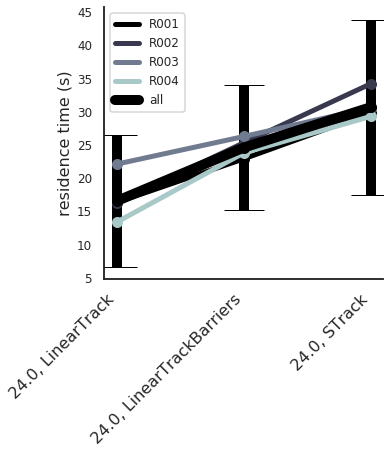

In [448]:
# Compare conditions holding track type or decay rate constant
exclude_cond = [k for k, v in cond_params.items() if (24 not in v or -1 in v)]
cond_order = [2, 4, 5]
data = t_p_obs

# Plot results
rc_params = {'axes.titlesize': 16,
             'axes.labelsize': 16,
             'xtick.labelsize': 16,
             'ytick.labelsize': 12,
             'legend.fontsize': 12,
             'legend.facecolor': 'inherit',
             'errorbar.capsize': 12.0}
plotter = plot.Plotter(rcParams=rc_params, cmap='bone')
plotter.plot_by_condition(t_p_obs, 
                          cond, 
                          cond_params,
                          exclude_cond=exclude_cond,
                          cond_order=cond_order,
                          center='mean',
                          err='std',
                          c=0.5,
                          linewidth=5,
                          markersize=10,
                          capsize=20,
                          figsize=(5, 5),
                          new_fig=True,
                          plot_subjects=True)
plotter.ax.set_ylabel('residence time (s)')

upload_figure('residence_time_vs_track_24.pdf', upload_folder_id, fmt='pdf')

#### Harvest rate (revisited)
We can now plot the harvest rate with the updated travel times as part of the denominator.

In [262]:
# Get harvest rate with non-foraging time subtracted
hr_ttmin = {}
for mouse_id in mouse_ids:
    # Placeholder
    hr_ttmin[mouse_id] = []
    
    for cond_i, r, t_p_ in zip(cond[mouse_id], r_obs[mouse_id], t_p_obs[mouse_id]):
        # Calculate harvest rate with minimum travel time for condition
        hr_ttmin[mouse_id].append(r / (t_p_ + t_t_min[mouse_id][cond_i]))

100% complete...
File sucessfully uploaded.


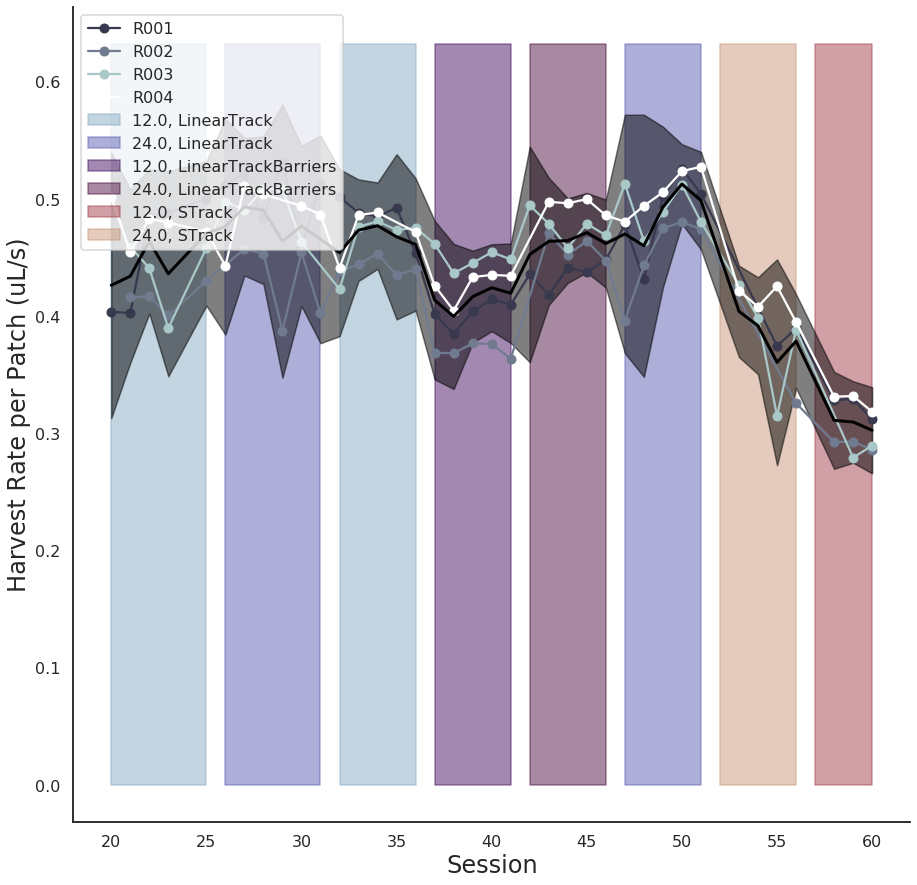

In [281]:
# Plot only from day 20 onwards (first day of exponential decay)
day_range = np.arange(20, 65)
day_range = {mouse_id: [day for day in include_days[mouse_id] if day in day_range]
             for mouse_id in mouse_ids}

# Get y-limits (unfortunately kind of hacky)
rc_params = {'axes.titlesize': 24,
             'axes.labelsize': 24,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'legend.fontsize': 16,
             'legend.facecolor': 'inherit'}
plotter = plot.Plotter(rcParams=rc_params)
plotter.plot_harvest_rates(days, 
                           hr_ttmin, 
                           new_fig=True,
                           day_range=day_range,
                           plot_traces=True, 
                           err='std', 
                           err_plot='fill', 
                           c=0.0)
ylim = [min(0.0,  plotter.ax.get_ylim()[0]), plotter.ax.get_ylim()[1]]

# Plot experimental conditions
sort_idx = np.argsort(days[mouse_id])
plotter.set_cmap('twilight')
plotter.create_new_figure(figsize=(15, 15))
for i, cond_i in enumerate(np.unique(cond_[mouse_id])[cond_order]):
    # Determine if barriers used
    if 'barriers' in cond_params[cond_i][1].lower():
        task_str = '+'
    else:
        task_str = '–'
        
    # Color exclude conditions white
    if cond_i in exclude_cond:
        plotter.ax.fill_between(days[mouse_id][sort_idx], *ylim, 
                            where=(cond[mouse_id][sort_idx] == cond_i), 
                            color='white', 
                            alpha=0.5,
                            label='pre-training')
    else:
        #label = 'tau={:.0f}, {}barriers'.format(cond_params[cond_i][0], task_str)
        label = '{}, {}'.format(*cond_params[cond_i])
        plotter.ax.fill_between(days[mouse_id][sort_idx], *ylim, 
                            where=(cond[mouse_id][sort_idx] == cond_i), 
                            color=plotter.cmap((i+1)/len(cond_params)), 
                            alpha=0.5,
                            label=label)

# Plot harvest rate (animals began decaying reward on day 13)
plotter.set_cmap('bone')
plotter.plot_harvest_rates(days, 
                           hr_ttmin, 
                           new_fig=False,
                           plot_traces=True,
                           day_range=day_range,
                           center='mean',
                           err='std', 
                           err_plot='fill', 
                           c=0.0)
#plotter.ax.set_xlim([min(day_range)-1, plotter.ax.get_xlim()[1]])
plotter.add_legend(loc='upper left')

# Upload figure
upload_figure('harvest_rate_foraging.pdf', upload_folder_id, fmt='pdf')

#### Patch residence time (revisited)
We can also plot the patch residence time vs. experimental condition.

100% complete...
File sucessfully uploaded.


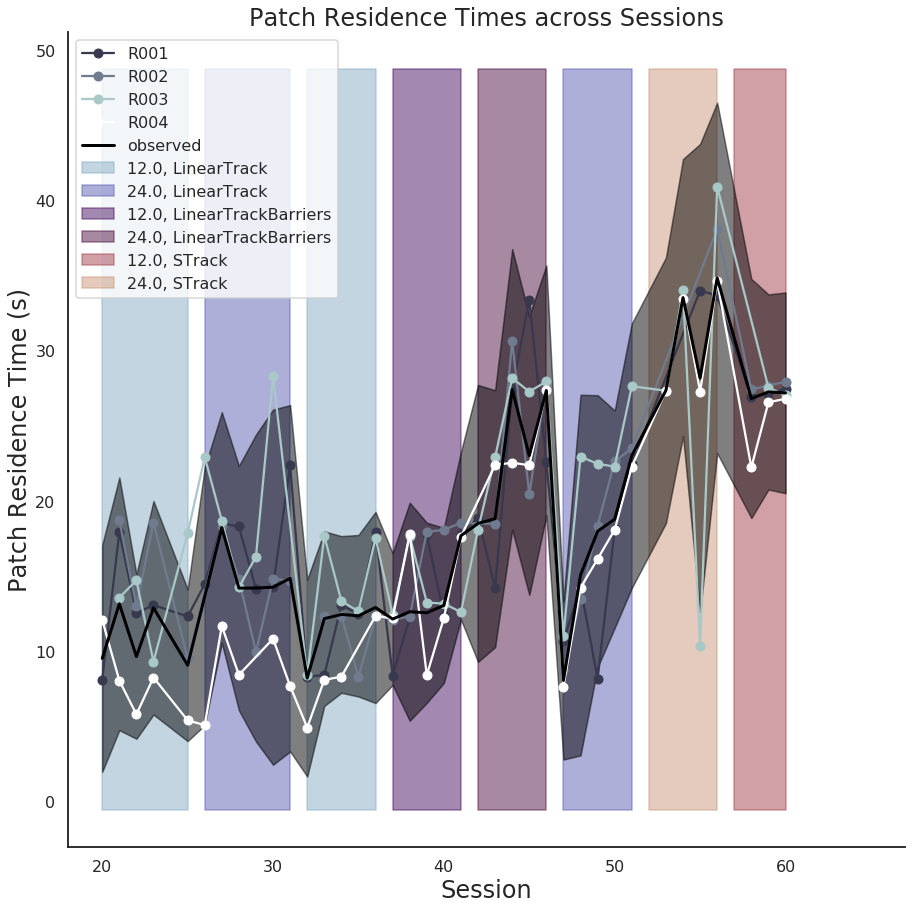

In [282]:
# Plot only from day 20 onwards (first day of exponential decay)
day_range = np.arange(20, 65)
day_range = {mouse_id: [day for day in include_days[mouse_id] if day in day_range]
             for mouse_id in mouse_ids}

# Get y-limits (unfortunately kind of hacky)
rc_params = {'axes.titlesize': 24,
             'axes.labelsize': 24,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'legend.fontsize': 16,
             'legend.facecolor': 'inherit'}
plotter = plot.Plotter(rcParams=rc_params)
plotter.plot_residence_times(days, 
                             t_p_obs, 
                             t_p_opt=None,
                             new_fig=True,
                             day_range=day_range,
                             plot_traces=True, 
                             err='std', 
                             err_plot='fill', 
                             c=0.0)
ylim = plotter.ax.get_ylim()

# Plot experimental conditions
sort_idx = np.argsort(days[mouse_id])
plotter.set_cmap('twilight')
plotter.create_new_figure(figsize=(15, 15))
for i, cond_i in enumerate(np.unique(cond_[mouse_id])[cond_order]):
    # Determine if barriers used
    if 'barriers' in cond_params[cond_i][1].lower():
        task_str = '+'
    else:
        task_str = '–'
        
    # Color exclude conditions white
    if cond_i in exclude_cond:
        plotter.ax.fill_between(days[mouse_id][sort_idx], *ylim, 
                            where=(cond[mouse_id][sort_idx] == cond_i), 
                            color='white', 
                            alpha=0.5,
                            label='pre-training')
    else:
        #label = 'tau={:.0f}, {}barriers'.format(cond_params[cond_i][0], task_str)
        label = '{}, {}'.format(*cond_params[cond_i])
        plotter.ax.fill_between(days[mouse_id][sort_idx], *ylim, 
                            where=(cond[mouse_id][sort_idx] == cond_i), 
                            color=plotter.cmap((i+1)/len(cond_params)), 
                            alpha=0.5,
                            label=label)

# Plot harvest rate (animals began decaying reward on day 13)
plotter.set_cmap('bone')
plotter.plot_residence_times(days, 
                             t_p_obs, 
                             t_p_opt=None,
                             new_fig=False,
                             day_range=day_range,
                             plot_traces=True, 
                             err='std', 
                             err_plot='fill', 
                             c=0.0)
#plotter.ax.set_xlim([min(day_range)-1, plotter.ax.get_xlim()[1]])
plotter.add_legend(loc='upper left')

# Upload figure
upload_figure('residence_time_vs_day_condition.pdf', upload_folder_id, fmt='pdf')

#### Compare control conditions
The order of training could affect animal performance. Do animals behave the same when the condition is repeated later in training?

In [342]:
print(cond_params)

{0: [12.0, 'LinearTrack'], 1: [-1, 'LinearTrack'], 2: [24.0, 'LinearTrack'], 3: [12.0, 'STrack'], 4: [24.0, 'LinearTrackBarriers'], 5: [24.0, 'STrack'], 6: [12.0, 'LinearTrackBarriers']}


In [343]:
# Find repeated conditions
# In this case, it will be:
# - condition 0: days 20-25 vs. 32-36
# - condition 2: days 26-31 vs. 47-51
cond_repeat_params = {-1: [''],
                       0: cond_params[0],
                       1: cond_params[0],
                       2: cond_params[2],
                       3: cond_params[2]}

# Assign new condition numbers
cond_repeat = {}
for mouse_id in mouse_ids:
    cond_repeat[mouse_id] = []
    for sess in sessions[mouse_id]:
        if sess.day in np.arange(20, 26):
            cond_repeat[mouse_id].append(0)
        elif sess.day in np.arange(32, 37):
            cond_repeat[mouse_id].append(1)
        elif sess.day in np.arange(26, 32):
            cond_repeat[mouse_id].append(2)
        elif sess.day in np.arange(47, 52):
            cond_repeat[mouse_id].append(3)
        else:
            cond_repeat[mouse_id].append(-1)

In [344]:
# Recalculate minimum and non-foraging times
t_t_min_repeat = {}
t_t_nf_repeat = {}
for mouse_id in mouse_ids:
    # Placeholder
    t_t_min_repeat[mouse_id] = {}
    t_t_nf_repeat[mouse_id] = []
    
    # Get travel time stats
    t_t_, cond_t = util.get_patch_statistics(t_t_obs[mouse_id],
                                             ids=cond_repeat[mouse_id],
                                             return_all=True)
    
    # Iterate over conditions to get travel time stats
    for cond_i in np.unique(cond_repeat[mouse_id]):
        # Get travel time stats for condition. Set to median of 
        # bottom tenth percentile of travel times.
        idx = np.argwhere(cond_i == cond_t).flatten()
        t_t_min_repeat[mouse_id][cond_i] = np.median(np.sort(t_t_[idx])[:max(len(idx)//10, 1)]) 
        
    # Iterate over sessions to get corrected travel times
    for j, cond_i in enumerate(cond_repeat[mouse_id]):
        # Question: correct for negative non-foraging times?
        t_t_nf_repeat[mouse_id].append(t_p_obs[mouse_id][j] - t_t_min_repeat[mouse_id][cond_i])

100% complete...
File sucessfully uploaded.


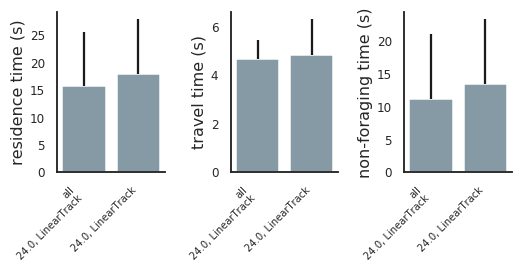

In [350]:
# Plot results
rc_params = {'axes.titlesize': 16,
             'axes.labelsize': 16,
             'xtick.labelsize': 10,
             'ytick.labelsize': 12,
             'legend.fontsize': 12,
             'legend.facecolor': 'inherit',
             'errorbar.capsize': 0.0}
cmap = plt.get_cmap('bone')
nrows = 1
ncols = 3
plotter = plot.Plotter(cmap=cmap, rcParams=rc_params)
plotter.create_new_figure(figsize=(2.5*ncols, 4*nrows), rows=nrows, cols=ncols)
exclude_cond = [-1, 0, 1]

# Plot residence times
plotter.set_current_axis(0)
plotter.bar_graph_by_condition(t_p_obs, 
                               cond_repeat, 
                               cond_repeat_params,
                               exclude_cond=exclude_cond,
                               cond_order=None,
                               center='mean',
                               err='std',
                               c=0.6,
                               new_fig=False,
                               plot_subjects=False)
plotter.ax.set_ylabel('residence time (s)')

# Plot minimum travel times
plotter.set_current_axis(1)
t_t_plot = {mouse_id: [t_t_min_repeat[mouse_id][cond_i] for cond_i in np.unique(cond_repeat[mouse_id])]
            for mouse_id in mouse_ids}
cond_plot = {mouse_id: list(np.unique(cond_repeat[mouse_id]))
             for mouse_id in mouse_ids}
plotter.bar_graph_by_condition(t_t_plot, 
                               cond_plot, 
                               cond_repeat_params,
                               exclude_cond=exclude_cond,
                               cond_order=None,
                               center='mean',
                               err='std',
                               c=0.6,
                               new_fig=False,
                               plot_subjects=False)
plotter.ax.set_ylabel('travel time (s)')

# Plot non-foraging times
plotter.set_current_axis(2)
plotter.bar_graph_by_condition(t_t_nf_repeat, 
                               cond_repeat, 
                               cond_repeat_params,
                               exclude_cond=exclude_cond,
                               cond_order=None,
                               center='mean',
                               err='std',
                               c=0.6,
                               new_fig=False,
                               plot_subjects=False)
plotter.ax.set_ylabel('non-foraging time (s)')

# Format plot
plt.tight_layout()

upload_figure('residence_travel_time_vs_condition_repeated_2.pdf', upload_folder_id, fmt='pdf')

## To-Do list
Run statistical tests on comparisons

Check correlation between residence and subsequent travel time and log travel time
- Make plot above nicer to demonstrate two things: 
    - No correlation between patch residence time and subsequent travel times means that we don't necessarily need to filter out travel times and previous residence times. Rather, we can simply subtract off the "excess" travel time when calculating harvest rate.
    - ??
    
How soon after reward do animals leave? Lick stats?

## Development

In [ ]:
# Statistical tests
# Get t-test results from all pairwise comparisons
        #pvalues[mouse_id] = {}
        #for k, cond_1 in enumerate(cond_plot[:-1]):
        #    for l, cond_2 in enumerate(cond_plot[k+1:]):
        #        idx_1 = np.argwhere(cond_all == cond_1).flatten()
        #        idx_2 = np.argwhere(cond_all == cond_2).flatten()
        #        _, pvalue = stats.ttest_rel(t_all[idx_1], t_all[idx_2])
        #        pvalues[mouse_id][cond_1][cond_2] = pvalue
        #        pvalues[mouse_id][cond_2][cond_1] = pvalue